In [1]:
from pathlib import Path
import os
os.environ["DATA_PATH"] = str(Path.home() / "proteina/data")
import subprocess
import json
import hydra
import lightning as L
import numpy as np
import pandas as pd
import scipy
import torch
from proteinfoundation.datasets.transforms import CATHLabelTransform
from Bio.PDB import PDBParser, PDBIO, is_aa
from tqdm import tqdm
from matplotlib import pyplot as plt


/home/jupyter-chenxi/.conda/envs/proteina/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Plots

In [2]:
alpha_1 = list("ARNDCQEGHILKMFPSTWYVX-")
states = len(alpha_1)
alpha_3 = ['ALA','ARG','ASN','ASP','CYS','GLN','GLU','GLY','HIS','ILE',
            'LEU','LYS','MET','PHE','PRO','SER','THR','TRP','TYR','VAL','UNK','GAP']

aa_1_N = {a:n for n,a in enumerate(alpha_1)}
aa_3_N = {a:n for n,a in enumerate(alpha_3)}
aa_N_1 = {n:a for n,a in enumerate(alpha_1)}
aa_N_3 = {n:a for n,a in enumerate(alpha_3)}
aa_1_3 = {a:b for a,b in zip(alpha_1,alpha_3)}
aa_3_1 = {b:a for a,b in zip(alpha_1,alpha_3)}


def get_atom_pdb(pdb_file, chain_id, atom_id="CA", model_id=0):
    pdb_parser = PDBParser(QUIET=True)
    pdb = pdb_parser.get_structure("", pdb_file)
    model = pdb[model_id]
    chain = model[chain_id]
    seq = []
    coords = []
    for res in chain.get_residues():
        if is_aa(res) and res.get_resname() in aa_3_1:
            # Append the coordinates of each atom
            # Skip any without a CA atom
            ca_coord = [atom.get_coord() for atom in res if atom.name == atom_id]
            if len(ca_coord) > 0:
                coords.append(ca_coord[0])
                seq.append(aa_3_1[res.get_resname()])
    # Convert coordinates list to numpy array
    coords = np.array(coords)
    return coords, seq

# Implement local distance difference test with cutoff of 0.5A, 1.0A, 2.0A, 4.0A. The global cutoff for averaging is 15A.
def compute_lddt(gt_coord, template_coord, cutoff=15, local_cutoff=[0.5, 1.0, 2.0, 4.0]):
    gt_dist = np.linalg.norm(gt_coord[None, :, :] - gt_coord[:, None, :], axis=-1)
    template_dist = np.linalg.norm(template_coord[None, :, :] - template_coord[:, None, :], axis=-1)
    global_dist_mask = gt_dist < cutoff
    dist_diff = np.abs(gt_dist - template_dist)
    local_dist_mask = np.zeros((len(local_cutoff), len(gt_coord), len(gt_coord)))
    for i, cutoff in enumerate(local_cutoff):
        local_dist_mask[i] = dist_diff < cutoff
    lddt = np.mean(local_dist_mask, axis=0)
    lddt = (global_dist_mask * lddt).sum(axis=0) / global_dist_mask.sum(axis=0)
    return lddt


In [11]:
data = torch.load(Path.home() / "proteina/data/pdb_train/processed/7ad5_A.pt", weights_only=False)

print(data.keys())
print(data["coords"].shape, type(data["coords"]))
print(data["coord_mask"].shape, type(data["coord_mask"]))


['seq_pos', 'coords', 'id', 'coord_mask', 'residue_type', 'bfactor_avg', 'bfactor', 'database', 'chains', 'residues', 'residue_id', 'residue_pdb_idx']
torch.Size([124, 37, 3]) <class 'torch.Tensor'>
torch.Size([124, 37]) <class 'torch.Tensor'>


In [ ]:
with open(Path.home() / "proteina/data/pdb_train/processed/files.txt", "a") as f:
    for file in os.listdir(Path.home() / "proteina/data/pdb_train/processed/"):
        file = Path(Path.home() / "proteina/data/pdb_train/processed/" / file)
        if file.is_file() and str(file).endswith(".pt"):
            f.write(f"{file.absolute()} {file.name[:-3]} -\n")


In [12]:
with open(Path.home() / "data/cath_v4-4/by_fold/3.30.70/files.txt", "a") as f:
    for file in os.listdir(Path.home() / "data/cath_v4-4/by_fold/3.30.70"):
        file = Path(Path.home() / "data/cath_v4-4/by_fold/3.30.70" / file)
        if file.is_file() and not file.name.endswith(".txt"):
            f.write(f"{file.absolute()} {file.name} -\n")


In [ ]:
db = torch.load(Path.home() / "progres/progres/databases/v_0_2_1/ark_scope40_CIRPIN_embed_1_7_25.pt", weights_only=False)
print(db.keys())
print(db["ids"][:10])
print(db["embeddings"][0])
print(db["notes"][0])


dict_keys(['ids', 'embeddings', 'nres', 'notes'])
['d2i49a_', 'd1z05a2', 'd3v3ea_', 'd1l9la_', 'd2pbea2', 'd1kr7a_', 'd5hhaa_', 'd1lwuc1', 'd6jbra_', 'd1xrda1']
tensor([ 0.0280, -0.1533, -0.0945,  0.0432,  0.0817,  0.0551,  0.0853, -0.1175,
        -0.0928, -0.0025, -0.0273,  0.0142, -0.0083,  0.0404,  0.1046,  0.1787,
         0.0927, -0.1918,  0.0229,  0.0914,  0.1530, -0.0022,  0.0013,  0.0376,
        -0.0560, -0.0023, -0.0511,  0.1062,  0.1093, -0.0728,  0.0130, -0.0062,
        -0.0856, -0.0444,  0.1324,  0.0044, -0.0434, -0.0903, -0.0441,  0.0961,
         0.0597, -0.0599,  0.0867, -0.0590, -0.0969,  0.0175,  0.0926,  0.0221,
        -0.2100,  0.0961, -0.1247,  0.0979, -0.0901,  0.0086, -0.0255,  0.0465,
        -0.0369,  0.0525, -0.0428,  0.0870, -0.1084, -0.0408, -0.0517,  0.1190,
        -0.1076,  0.1487,  0.0337, -0.1079, -0.0229,  0.0969,  0.0154, -0.0562,
         0.0491,  0.0470, -0.0457,  0.0092, -0.0299,  0.0503,  0.0886,  0.1292,
         0.0125,  0.0947, -0.1490, -0.0

In [3]:
db = torch.load(Path.home() / "progres/progres/databases/v_0_2_1/pdb_max384.pt", weights_only=False)
print(db.keys())
print(db["ids"][:10])
print(db["embeddings"][0])
print(db["notes"][0])


dict_keys(['ids', 'embeddings', 'nres', 'notes'])
['8hi1_F', '8u8s_B', '1kzo_A', '5c9h_B', '3pa2_A', '4pdw_D', '1j5e_C', '1ddl_C', '5no5_A', '2c80_B']
tensor([ 0.0580, -0.0530, -0.0558, -0.2764, -0.0121,  0.2451,  0.0506,  0.0313,
         0.0177, -0.0249, -0.1617, -0.0555,  0.0180,  0.1046,  0.1405,  0.1102,
         0.1388, -0.0318, -0.0403, -0.0909,  0.0619,  0.0384,  0.0159,  0.0284,
         0.0091, -0.0395,  0.0075, -0.0356, -0.1266, -0.0357,  0.0633,  0.0079,
        -0.0182, -0.0305, -0.0769,  0.0370, -0.0351, -0.0249, -0.0952,  0.1212,
        -0.0039,  0.0252, -0.0562, -0.0232,  0.0003, -0.1582,  0.0450,  0.0755,
         0.0262,  0.0574, -0.1930, -0.0464, -0.0012,  0.1015,  0.0116, -0.0498,
         0.0481,  0.0560,  0.0164,  0.0407,  0.1002, -0.0731,  0.0014, -0.0746,
        -0.0422,  0.1320,  0.1680, -0.1177, -0.1181,  0.1498, -0.0849, -0.1646,
         0.0742, -0.0377,  0.0319, -0.1493,  0.0142,  0.1570,  0.1697, -0.0509,
        -0.1582,  0.1181, -0.0422, -0.0389,  0.13

In [ ]:
cath_code_files = [f for f in os.listdir(Path.home() / "proteina/data/pdb_train/") if f.startswith("cath_codes")]

for f in cath_code_files:
    cath_code_df = pd.read_csv(Path.home() / "proteina/data/pdb_train/" / f)
    fold_code_df = pd.DataFrame(cath_code_df["cath_code"].str.split(".").str[:3].str.join(".").unique(), columns=["cath_code"])
    new_f = "unique_fold_" + str(f)
    fold_code_df.to_csv(Path.home() / "proteina/data/pdb_train/" / new_f, index=False)


unique_fold_cath_codes_test_df_pdb_f1_minl50_maxl256_mtprotein_etdiffractionEM_minoNone_maxoNone_minr0.0_maxr5.0_hl_rl_rnsrTrue_rpuTrue_l_rcuFalse.csv
unique_fold_cath_codes_train_df_pdb_f1_minl50_maxl384_mtprotein_etdiffractionEM_minoNone_maxoNone_minr0.0_maxr5.0_hl_rl_rnsrTrue_rpuTrue_l_rcuFalse_ex11.csv
unique_fold_cath_codes_val_df_pdb_f1_minl50_maxl384_mtprotein_etdiffractionEM_minoNone_maxoNone_minr0.0_maxr5.0_hl_rl_rnsrTrue_rpuTrue_l_rcuFalse_ex11.csv
unique_fold_cath_codes_val_df_pdb_f1_minl50_maxl256_mtprotein_etdiffractionEM_minoNone_maxoNone_minr0.0_maxr5.0_hl_rl_rnsrTrue_rpuTrue_l_rcuFalse.csv
unique_fold_cath_codes_test_df_pdb_f1_minl50_maxl384_mtprotein_etdiffractionEM_minoNone_maxoNone_minr0.0_maxr5.0_hl_rl_rnsrTrue_rpuTrue_l_rcuFalse_ex11.csv
unique_fold_cath_codes_train_df_pdb_f1_minl50_maxl256_mtprotein_etdiffractionEM_minoNone_maxoNone_minr0.0_maxr5.0_hl_rl_rnsrTrue_rpuTrue_l_rcuFalse.csv


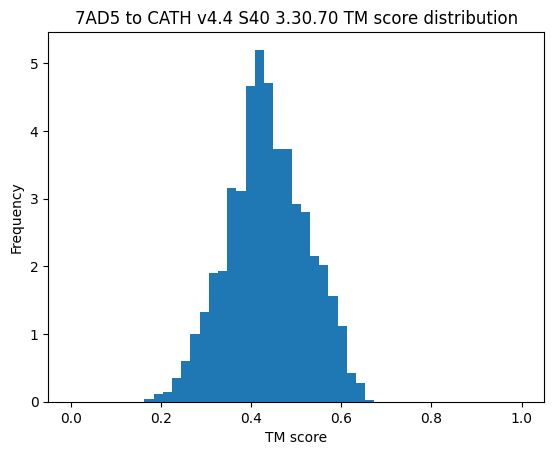

In [7]:
control_aln_df = pd.read_csv(Path.home() / "data/cath_v4-4/7ad5_3.30.70_aln.tsv", sep="\t")

plt.hist(np.concatenate([control_aln_df["TM1"].to_numpy(), control_aln_df["TM2"].to_numpy()]), bins=np.linspace(0, 1, 50), density=True)
plt.xlabel("TM score")
plt.ylabel("Frequency")
plt.title("7AD5 to CATH v4.4 S40 3.30.70 TM score distribution")
plt.show()


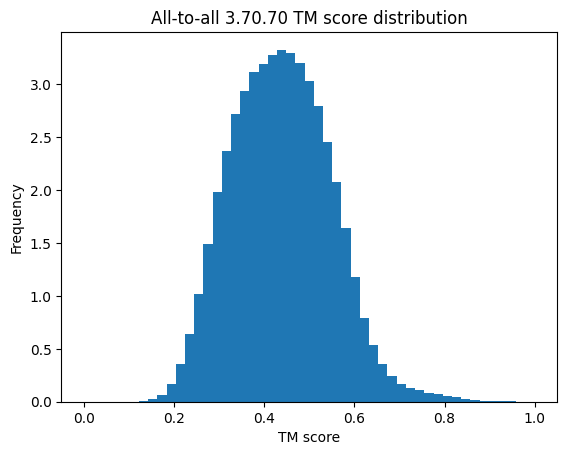

In [6]:
control_aln_df = pd.read_csv(Path.home() / "cath_v4-4_3.70.70_aln.tsv", sep="\t")

plt.hist(control_aln_df["TM1"].to_numpy(), bins=np.linspace(0, 1, 50), density=True)
plt.xlabel("TM score")
plt.ylabel("Frequency")
plt.title("All-to-all 3.70.70 TM score distribution")
plt.show()


In [ ]:
seq_cirpin_045_noise_aln_df = pd.read_csv(Path.home() / "proteina/inference/inference_seq_cirpin_cond_sampling_finetune-all_4-seq_64-cirpin_purge-7bny-7kww-7ad5-7b76_045-noise/7ad5_A/aln.tsv", sep="\t")
seq_cirpin_sample_045_noise_aln_df = pd.read_csv(Path.home() / "proteina/inference/inference_seq_cirpin_cond_sampling_finetune-all_4-seq_64-cirpin-sample_purge-7bny-7kww-7ad5-7b76_045-noise/7ad5_A/aln.tsv", sep="\t")
template_aln_df = pd.read_csv(Path.home() / "data/cath_v4-4/7ad5_3.30.70_aln.tsv", sep="\t")
template_aln_df["PDBchain2"] = template_aln_df["PDBchain2"].str.replace("/./", "").str.replace(":A", "")
template_aln_df.head()


/tmp/ipykernel_786692/3086337559.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  template_aln_df["PDBchain2"] = template_aln_df["PDBchain2"].str.replace("/./", "").str.replace(":A", "")


,#PDBchain1,PDBchain2,TM1,TM2,RMSD,ID1,ID2,IDali,L1,L2,Lali
0,/home/jupyter-chenxi/7ad5.pdb:A,4dmzA02,0.4809,0.4453,3.55,0.056,0.051,0.082,124,137,85
1,/home/jupyter-chenxi/7ad5.pdb:A,4erdA00,0.3766,0.4204,3.66,0.008,0.009,0.014,124,106,70
2,/home/jupyter-chenxi/7ad5.pdb:A,1oo0B00:B,0.4201,0.5206,3.60,0.065,0.087,0.105,124,92,76
3,/home/jupyter-chenxi/7ad5.pdb:A,1vjqA00,0.3816,0.5658,3.18,0.024,0.042,0.046,124,71,65
4,/home/jupyter-chenxi/7ad5.pdb:A,6hhnA01,0.3997,0.4841,3.76,0.048,0.065,0.077,124,92,78


In [ ]:
seq_045_noise_aln_df = pd.read_csv(Path.home() / "proteina/inference/inference_seq_cond_sampling_finetune-all_8-seq_purge-7bny-7kww-7ad5_045-noise/7ad5_A/paired_aln.tsv", sep="\t")
seq_cath_045_noise_aln_df = pd.read_csv(Path.home() / "proteina/inference/inference_seq_cath_cond_sampling_finetune-all_8-seq_purge-7bny-7kww-7ad5_045-noise/7ad5_A/paired_aln.tsv", sep="\t")
cath_045_noise_aln_df = pd.read_csv(Path.home() / "proteina/inference/inference_cath_cond_sampling_v1-6-control_045-noise/paired_aln.tsv", sep="\t")
seq_045_cutoff_190828_epoch_17_aln_df = pd.read_csv(Path.home() / "proteina/inference/inference_seq_cond_sampling_finetune-all_8-seq_purge-7bny-7kww-7ad5_045-noise/7ad5_A/paired_aln.tsv", sep="\t")

# Make the two groups with no CATH two similiar but different colors and the two groups with CATH two similiar colors
plt.hist(seq_045_noise_aln_df["TM1"].to_numpy(), alpha=0.3, bins=np.linspace(0, 1, 50), label=f"seq_045-noise, max={seq_045_noise_aln_df['TM1'].max():.2f}", density=True, color=(0, 0, 1))
# plt.hist(seq_cath_045_noise_aln_df["TM1"].to_numpy(), alpha=0.3, bins=np.linspace(0, 1, 50), label=f"seq_CATH_045-noise, max={seq_cath_045_noise_aln_df['TM1'].max():.2f}", density=True, color=(1, 0, 0))
# plt.hist(seq_cath_060_noise_aln_df["TM1"].to_numpy(), alpha=0.3, bins=np.linspace(0, 1, 50), label=f"seq_CATH_060-noise, max={seq_cath_060_noise_aln_df['TM1'].max():.2f}", density=True, color=(1, 0.4, 0))
plt.hist(seq_cath_045_noise_aln_df[seq_cath_045_noise_aln_df["PDBchain2"].str.contains("3.30.70")]["TM1"].to_numpy(), alpha=0.3, bins=np.linspace(0, 1, 50), label=f"seq_CATH_045-noise_3.70.70, max={seq_cath_045_noise_aln_df[seq_cath_045_noise_aln_df['PDBchain2'].str.contains('3.30.70')]['TM1'].max():.2f}", density=True, color=(0, 1, 0))
plt.hist(cath_045_noise_aln_df["TM1"].to_numpy(), alpha=0.3, bins=np.linspace(0, 1, 50), label=f"cath_045-noise, max={cath_045_noise_aln_df['TM1'].max():.2f}", density=True, color=(0.7, 0.7, 0.7))

plt.xlabel("TM score")
plt.ylabel("Frequency")
plt.xlim(0,0.6)
plt.title("7ad5_A Sequence Paired TM score distribution")
plt.legend()
plt.show()

# Get the top 3 TM scores for each model
print(seq_045_noise_aln_df.sort_values(["TM1"], ascending=False).head(3))
print(seq_060_noise_aln_df.sort_values(["TM1"], ascending=False).head(3))
print(seq_cath_045_noise_aln_df.sort_values(["TM1"], ascending=False).head(3))
print(seq_cath_060_noise_aln_df.sort_values(["TM1"], ascending=False).head(3))
print(cath_045_noise_aln_df.sort_values(["TM1"], ascending=False).head(3))


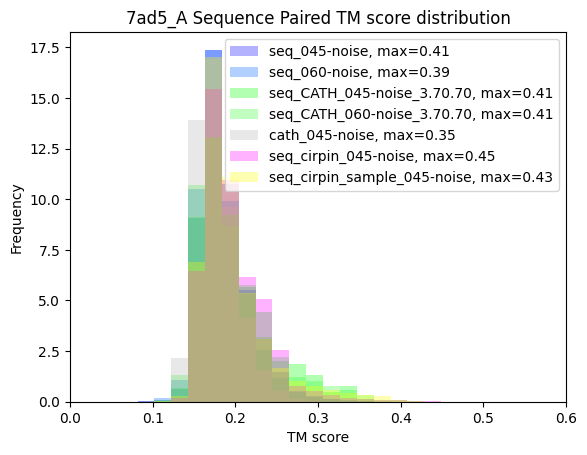

                                              #PDBchain1  \
8421   /home/jupyter-chenxi/proteina/data/pdb_train/r...   
22578  /home/jupyter-chenxi/proteina/data/pdb_train/r...   
9695   /home/jupyter-chenxi/proteina/data/pdb_train/r...   

                                PDBchain2     TM1     TM2  RMSD    ID1    ID2  \
8421    /./7ad5_A_cath_x.x.x.x_8421.pdb:A  0.4065  0.4065  6.54  0.048  0.048   
22578  /./7ad5_A_cath_x.x.x.x_22578.pdb:A  0.3742  0.3742  6.40  0.048  0.048   
9695    /./7ad5_A_cath_x.x.x.x_9695.pdb:A  0.3729  0.3729  7.58  0.048  0.048   

       IDali   L1   L2  Lali  
8421   0.049  124  124   122  
22578  0.049  124  124   122  
9695   0.049  124  124   122  
                                              #PDBchain1  \
21437  /home/jupyter-chenxi/proteina/data/pdb_train/r...   
1284   /home/jupyter-chenxi/proteina/data/pdb_train/r...   
17838  /home/jupyter-chenxi/proteina/data/pdb_train/r...   

                                PDBchain2     TM1     TM2  RMSD    ID

In [4]:
seq_045_noise_aln_df = pd.read_csv(Path.home() / "proteina/inference/inference_seq_cond_sampling_finetune-all_8-seq_purge-7bny-7kww-7ad5_045-noise/7ad5_A/paired_aln.tsv", sep="\t")
seq_060_noise_aln_df = pd.read_csv(Path.home() / "proteina/inference/inference_seq_cond_sampling_finetune-all_8-seq_purge-7bny-7kww-7ad5_060-noise/7ad5_A/paired_aln.tsv", sep="\t")
seq_cath_045_noise_aln_df = pd.read_csv(Path.home() / "proteina/inference/inference_seq_cath_cond_sampling_finetune-all_8-seq_purge-7bny-7kww-7ad5_045-noise/7ad5_A/paired_aln.tsv", sep="\t")
seq_cath_060_noise_aln_df = pd.read_csv(Path.home() / "proteina/inference/inference_seq_cath_cond_sampling_finetune-all_8-seq_purge-7bny-7kww-7ad5_060-noise/7ad5_A/paired_aln.tsv", sep="\t")
cath_045_noise_aln_df = pd.read_csv(Path.home() / "proteina/inference/inference_cath_cond_sampling_v1-6-control_045-noise/paired_aln.tsv", sep="\t")
seq_cirpin_045_noise_aln_df = pd.read_csv(Path.home() / "proteina/inference/inference_seq_cirpin_cond_sampling_finetune-all_4-seq_64-cirpin_purge-7bny-7kww-7ad5-7b76_045-noise/7ad5_A/paired_aln.tsv", sep="\t")
seq_cirpin_sample_045_noise_aln_df = pd.read_csv(Path.home() / "proteina/inference/inference_seq_cirpin_cond_sampling_finetune-all_4-seq_64-cirpin-sample_purge-7bny-7kww-7ad5-7b76_045-noise/7ad5_A/paired_aln.tsv", sep="\t")

# Make the two groups with no CATH two similiar but different colors and the two groups with CATH two similiar colors
plt.hist(seq_045_noise_aln_df["TM1"].to_numpy(), alpha=0.3, bins=np.linspace(0, 1, 50), label=f"seq_045-noise, max={seq_045_noise_aln_df['TM1'].max():.2f}", density=True, color=(0, 0, 1))
plt.hist(seq_060_noise_aln_df["TM1"].to_numpy(), alpha=0.3, bins=np.linspace(0, 1, 50), label=f"seq_060-noise, max={seq_060_noise_aln_df['TM1'].max():.2f}", density=True, color=(0, 0.4, 1))
# plt.hist(seq_cath_045_noise_aln_df["TM1"].to_numpy(), alpha=0.3, bins=np.linspace(0, 1, 50), label=f"seq_CATH_045-noise, max={seq_cath_045_noise_aln_df['TM1'].max():.2f}", density=True, color=(1, 0, 0))
# plt.hist(seq_cath_060_noise_aln_df["TM1"].to_numpy(), alpha=0.3, bins=np.linspace(0, 1, 50), label=f"seq_CATH_060-noise, max={seq_cath_060_noise_aln_df['TM1'].max():.2f}", density=True, color=(1, 0.4, 0))
plt.hist(seq_cath_045_noise_aln_df[seq_cath_045_noise_aln_df["PDBchain2"].str.contains("3.30.70")]["TM1"].to_numpy(), alpha=0.3, bins=np.linspace(0, 1, 50), label=f"seq_CATH_045-noise_3.70.70, max={seq_cath_045_noise_aln_df[seq_cath_045_noise_aln_df['PDBchain2'].str.contains('3.30.70')]['TM1'].max():.2f}", density=True, color=(0, 1, 0))
plt.hist(seq_cath_060_noise_aln_df[seq_cath_060_noise_aln_df["PDBchain2"].str.contains("3.30.70")]["TM1"].to_numpy(), alpha=0.3, bins=np.linspace(0, 1, 50), label=f"seq_CATH_060-noise_3.70.70, max={seq_cath_060_noise_aln_df[seq_cath_060_noise_aln_df['PDBchain2'].str.contains('3.30.70')]['TM1'].max():.2f}", density=True, color=(0.2, 1, 0.2))
plt.hist(cath_045_noise_aln_df["TM1"].to_numpy(), alpha=0.3, bins=np.linspace(0, 1, 50), label=f"cath_045-noise, max={cath_045_noise_aln_df['TM1'].max():.2f}", density=True, color=(0.7, 0.7, 0.7))
plt.hist(seq_cirpin_045_noise_aln_df["TM1"].to_numpy(), alpha=0.3, bins=np.linspace(0, 1, 50), label=f"seq_cirpin_045-noise, max={seq_cirpin_045_noise_aln_df['TM1'].max():.2f}", density=True, color=(1, 0, 1))
plt.hist(seq_cirpin_sample_045_noise_aln_df["TM1"].to_numpy(), alpha=0.3, bins=np.linspace(0, 1, 50), label=f"seq_cirpin_sample_045-noise, max={seq_cirpin_sample_045_noise_aln_df['TM1'].max():.2f}", density=True, color=(1, 1, 0))

plt.xlabel("TM score")
plt.ylabel("Frequency")
plt.xlim(0,0.6)
plt.title("7ad5_A Sequence Paired TM score distribution")
plt.legend()
plt.show()

# Get the top 3 TM scores for each model
print(seq_045_noise_aln_df.sort_values(["TM1"], ascending=False).head(3))
print(seq_060_noise_aln_df.sort_values(["TM1"], ascending=False).head(3))
print(seq_cath_045_noise_aln_df.sort_values(["TM1"], ascending=False).head(3))
print(seq_cath_060_noise_aln_df.sort_values(["TM1"], ascending=False).head(3))
print(cath_045_noise_aln_df.sort_values(["TM1"], ascending=False).head(3))
print(seq_cirpin_045_noise_aln_df.sort_values(["TM1"], ascending=False).head(3))
print(seq_cirpin_sample_045_noise_aln_df.sort_values(["TM1"], ascending=False).head(3))


/home/jupyter-chenxi/.conda/envs/proteina/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


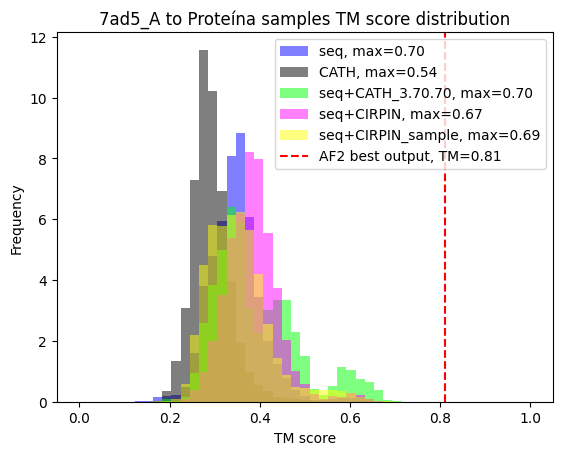

                                              #PDBchain1  \
17073  /home/jupyter-chenxi/proteina/data/pdb_train/r...   
16061  /home/jupyter-chenxi/proteina/data/pdb_train/r...   
10517  /home/jupyter-chenxi/proteina/data/pdb_train/r...   

                                PDBchain2     TM1     TM2  RMSD    ID1    ID2  \
17073  /./7ad5_A_cath_x.x.x.x_17073.pdb:A  0.7032  0.7032  3.21  0.742  0.742   
16061  /./7ad5_A_cath_x.x.x.x_16061.pdb:A  0.6864  0.6864  3.11  0.573  0.573   
10517  /./7ad5_A_cath_x.x.x.x_10517.pdb:A  0.6800  0.6800  2.94  0.710  0.710   

       IDali   L1   L2  Lali  
17073  0.793  124  124   116  
16061  0.623  124  124   114  
10517  0.772  124  124   114  
                                              #PDBchain1  \
4713   /home/jupyter-chenxi/proteina/data/pdb_train/r...   
29656  /home/jupyter-chenxi/proteina/data/pdb_train/r...   
28610  /home/jupyter-chenxi/proteina/data/pdb_train/r...   

                                 PDBchain2     TM1     TM2  RMSD    I

In [5]:
seq_045_noise_aln_df = pd.read_csv(Path.home() / "proteina/inference/inference_seq_cond_sampling_finetune-all_8-seq_purge-7bny-7kww-7ad5_045-noise/7ad5_A/aln.tsv", sep="\t")
# seq_060_noise_aln_df = pd.read_csv(Path.home() / "proteina/inference/inference_seq_cond_sampling_finetune-all_8-seq_purge-7bny-7kww-7ad5_060-noise/7ad5_A/aln.tsv", sep="\t")
seq_cath_045_noise_aln_df = pd.read_csv(Path.home() / "proteina/inference/inference_seq_cath_cond_sampling_finetune-all_8-seq_purge-7bny-7kww-7ad5_045-noise/7ad5_A/aln.tsv", sep="\t")
# seq_cath_060_noise_aln_df = pd.read_csv(Path.home() / "proteina/inference/inference_seq_cath_cond_sampling_finetune-all_8-seq_purge-7bny-7kww-7ad5_060-noise/7ad5_A/aln.tsv", sep="\t")
cath_045_noise_aln_df = pd.read_csv(Path.home() / "proteina/inference/inference_cath_cond_sampling_v1-6-control_045-noise/aln.tsv", sep="\t")
seq_cirpin_045_noise_aln_df = pd.read_csv(Path.home() / "proteina/inference/inference_seq_cirpin_cond_sampling_finetune-all_4-seq_64-cirpin_purge-7bny-7kww-7ad5-7b76_045-noise/7ad5_A/aln.tsv", sep="\t")
seq_cirpin_sample_045_noise_aln_df = pd.read_csv(Path.home() / "proteina/inference/inference_seq_cirpin_cond_sampling_finetune-all_4-seq_64-cirpin-sample_purge-7bny-7kww-7ad5-7b76_045-noise/7ad5_A/aln.tsv", sep="\t")

# Make the two groups with no CATH two similiar but different colors and the two groups with CATH two similiar colors
plt.hist(seq_045_noise_aln_df["TM1"].to_numpy(), alpha=0.5, bins=np.linspace(0, 1, 50), label=f"seq, max={seq_045_noise_aln_df['TM1'].max():.2f}", density=True, color=(0, 0, 1))
# plt.hist(seq_060_noise_aln_df["TM1"].to_numpy(), alpha=0.3, bins=np.linspace(0, 1, 50), label=f"seq_060-noise, max={seq_060_noise_aln_df['TM1'].max():.2f}", density=True, color=(0, 0.4, 1))
plt.hist(cath_045_noise_aln_df["TM1"].to_numpy(), alpha=0.5, bins=np.linspace(0, 1, 50), label=f"CATH, max={cath_045_noise_aln_df['TM1'].max():.2f}", density=True, color=(0, 0, 0))
# plt.hist(seq_cath_045_noise_aln_df["TM1"].to_numpy(), alpha=0.3, bins=np.linspace(0, 1, 50), label=f"seq_CATH_045-noise, max={seq_cath_045_noise_aln_df['TM1'].max():.2f}", density=True, color=(1, 0, 0))
# plt.hist(seq_cath_060_noise_aln_df["TM1"].to_numpy(), alpha=0.3, bins=np.linspace(0, 1, 50), label=f"seq_CATH_060-noise, max={seq_cath_060_noise_aln_df['TM1'].max():.2f}", density=True, color=(1, 0.4, 0))
plt.hist(seq_cath_045_noise_aln_df[seq_cath_045_noise_aln_df["PDBchain2"].str.contains("3.30.70")]["TM1"].to_numpy(), alpha=0.5, bins=np.linspace(0, 1, 50), label=f"seq+CATH_3.70.70, max={seq_cath_045_noise_aln_df[seq_cath_045_noise_aln_df['PDBchain2'].str.contains('3.30.70')]['TM1'].max():.2f}", density=True, color=(0, 1, 0))
# plt.hist(seq_cath_060_noise_aln_df[seq_cath_060_noise_aln_df["PDBchain2"].str.contains("3.30.70")]["TM1"].to_numpy(), alpha=0.3, bins=np.linspace(0, 1, 50), label=f"seq_CATH_060-noise_3.70.70, max={seq_cath_060_noise_aln_df[seq_cath_060_noise_aln_df['PDBchain2'].str.contains('3.30.70')]['TM1'].max():.2f}", density=True, color=(0.2, 1, 0.2))
plt.hist(seq_cirpin_045_noise_aln_df["TM1"].to_numpy(), alpha=0.5, bins=np.linspace(0, 1, 50), label=f"seq+CIRPIN, max={seq_cirpin_045_noise_aln_df['TM1'].max():.2f}", density=True, color=(1, 0, 1))
plt.hist(seq_cirpin_sample_045_noise_aln_df["TM1"].to_numpy(), alpha=0.5, bins=np.linspace(0, 1, 50), label=f"seq+CIRPIN_sample, max={seq_cirpin_sample_045_noise_aln_df['TM1'].max():.2f}", density=True, color=(1, 1, 0))
plt.axvline(x=0.81, color="red", linestyle="--", label="AF2 best output, TM=0.81")

# Display the figure in high resolution
plt.xlabel("TM score")
plt.ylabel("Frequency")
plt.title("7ad5_A to Proteína samples TM score distribution")
plt.legend()
plt.savefig(Path.home() / "poster_7ad5_A_aln_tm_score_distribution.png", dpi=300)
plt.show() 

# Get the top 3 TM scores for each model
print(seq_045_noise_aln_df.sort_values(["TM1"], ascending=False).head(3))
# print(seq_060_noise_aln_df.sort_values(["TM1"], ascending=False).head(3))
print(seq_cath_045_noise_aln_df.sort_values(["TM1"], ascending=False).head(3))
# print(seq_cath_060_noise_aln_df.sort_values(["TM1"], ascending=False).head(3))
print(cath_045_noise_aln_df.sort_values(["TM1"], ascending=False).head(3))
print(seq_cirpin_045_noise_aln_df.sort_values(["TM1"], ascending=False).head(3))
print(seq_cirpin_sample_045_noise_aln_df.sort_values(["TM1"], ascending=False).head(3))


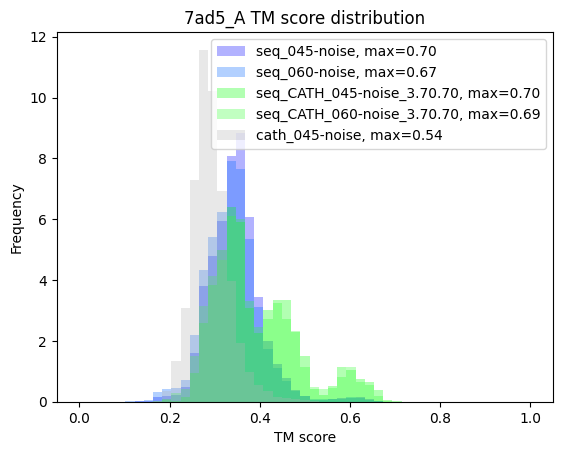

                                              #PDBchain1  \
17073  /home/jupyter-chenxi/proteina/data/pdb_train/r...   
16061  /home/jupyter-chenxi/proteina/data/pdb_train/r...   
10517  /home/jupyter-chenxi/proteina/data/pdb_train/r...   

                                PDBchain2     TM1     TM2  RMSD    ID1    ID2  \
17073  /./7ad5_A_cath_x.x.x.x_17073.pdb:A  0.7032  0.7032  3.21  0.742  0.742   
16061  /./7ad5_A_cath_x.x.x.x_16061.pdb:A  0.6864  0.6864  3.11  0.573  0.573   
10517  /./7ad5_A_cath_x.x.x.x_10517.pdb:A  0.6800  0.6800  2.94  0.710  0.710   

       IDali   L1   L2  Lali  
17073  0.793  124  124   116  
16061  0.623  124  124   114  
10517  0.772  124  124   114  
                                              #PDBchain1  \
1471   /home/jupyter-chenxi/proteina/data/pdb_train/r...   
20410  /home/jupyter-chenxi/proteina/data/pdb_train/r...   
5446   /home/jupyter-chenxi/proteina/data/pdb_train/r...   

                                PDBchain2     TM1     TM2  RMSD    ID

In [ ]:
seq_045_noise_aln_df = pd.read_csv(Path.home() / "proteina/inference/inference_seq_cond_sampling_finetune-all_8-seq_purge-7bny-7kww-7ad5_045-noise/7ad5_A/aln.tsv", sep="\t")
seq_060_noise_aln_df = pd.read_csv(Path.home() / "proteina/inference/inference_seq_cond_sampling_finetune-all_8-seq_purge-7bny-7kww-7ad5_060-noise/7ad5_A/aln.tsv", sep="\t")
seq_cath_045_noise_aln_df = pd.read_csv(Path.home() / "proteina/inference/inference_seq_cath_cond_sampling_finetune-all_8-seq_purge-7bny-7kww-7ad5_045-noise/7ad5_A/aln.tsv", sep="\t")
seq_cath_060_noise_aln_df = pd.read_csv(Path.home() / "proteina/inference/inference_seq_cath_cond_sampling_finetune-all_8-seq_purge-7bny-7kww-7ad5_060-noise/7ad5_A/aln.tsv", sep="\t")
cath_045_noise_aln_df = pd.read_csv(Path.home() / "proteina/inference/inference_cath_cond_sampling_v1-6-control_045-noise/aln.tsv", sep="\t")

# Make the two groups with no CATH two similiar but different colors and the two groups with CATH two similiar colors
plt.hist(seq_045_noise_aln_df["TM1"].to_numpy(), alpha=0.3, bins=np.linspace(0, 1, 50), label=f"seq_045-noise, max={seq_045_noise_aln_df['TM1'].max():.2f}", density=True, color=(0, 0, 1))
plt.hist(seq_060_noise_aln_df["TM1"].to_numpy(), alpha=0.3, bins=np.linspace(0, 1, 50), label=f"seq_060-noise, max={seq_060_noise_aln_df['TM1'].max():.2f}", density=True, color=(0, 0.4, 1))
# plt.hist(seq_cath_045_noise_aln_df["TM1"].to_numpy(), alpha=0.3, bins=np.linspace(0, 1, 50), label=f"seq_CATH_045-noise, max={seq_cath_045_noise_aln_df['TM1'].max():.2f}", density=True, color=(1, 0, 0))
# plt.hist(seq_cath_060_noise_aln_df["TM1"].to_numpy(), alpha=0.3, bins=np.linspace(0, 1, 50), label=f"seq_CATH_060-noise, max={seq_cath_060_noise_aln_df['TM1'].max():.2f}", density=True, color=(1, 0.4, 0))
plt.hist(seq_cath_045_noise_aln_df[seq_cath_045_noise_aln_df["PDBchain2"].str.contains("3.30.70")]["TM1"].to_numpy(), alpha=0.3, bins=np.linspace(0, 1, 50), label=f"seq_CATH_045-noise_3.70.70, max={seq_cath_045_noise_aln_df[seq_cath_045_noise_aln_df['PDBchain2'].str.contains('3.30.70')]['TM1'].max():.2f}", density=True, color=(0, 1, 0))
plt.hist(seq_cath_060_noise_aln_df[seq_cath_060_noise_aln_df["PDBchain2"].str.contains("3.30.70")]["TM1"].to_numpy(), alpha=0.3, bins=np.linspace(0, 1, 50), label=f"seq_CATH_060-noise_3.70.70, max={seq_cath_060_noise_aln_df[seq_cath_060_noise_aln_df['PDBchain2'].str.contains('3.30.70')]['TM1'].max():.2f}", density=True, color=(0.2, 1, 0.2))
plt.hist(cath_045_noise_aln_df["TM1"].to_numpy(), alpha=0.3, bins=np.linspace(0, 1, 50), label=f"cath_045-noise, max={cath_045_noise_aln_df['TM1'].max():.2f}", density=True, color=(0.7, 0.7, 0.7))

plt.xlabel("TM score")
plt.ylabel("Frequency")
plt.title("7ad5_A TM score distribution")
plt.legend()
plt.show() 

# Get the top 3 TM scores for each model
print(seq_045_noise_aln_df.sort_values(["TM1"], ascending=False).head(3))
print(seq_060_noise_aln_df.sort_values(["TM1"], ascending=False).head(3))
print(seq_cath_045_noise_aln_df.sort_values(["TM1"], ascending=False).head(3))
print(seq_cath_060_noise_aln_df.sort_values(["TM1"], ascending=False).head(3))


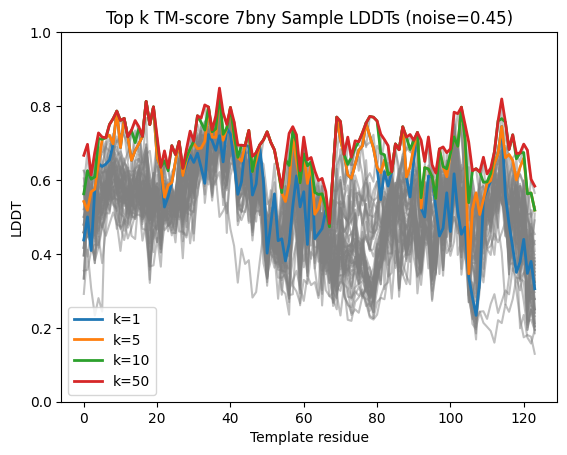

In [8]:
gt_pdb = Path.home() / "7ad5.pdb"
gt_coord, gt_seq = get_atom_pdb(gt_pdb, "A")
top_k = 50
template_pdbs = seq_045_noise_aln_df.sort_values(by="TM1", ascending=False).head(top_k)["PDBchain2"]
lddt_list = []
for template_pdb in template_pdbs:
    template_pdb = Path(Path.home() / "proteina/inference/inference_seq_cond_sampling_finetune-all_8-seq_purge-7bny-7kww-7ad5_045-noise/7ad5_A") / template_pdb.split(":")[0][1:]
    template_coord, template_seq = get_atom_pdb(template_pdb, "A")

    lddt = compute_lddt(gt_coord, template_coord, cutoff=15, local_cutoff=[0.5, 1.0, 2.0, 4.0])
    lddt_list.append(lddt)

for i in range(len(lddt_list)): plt.plot(lddt_list[i], alpha=0.5, color="gray")
for k in [1 , 5, 10, 50]: plt.plot(np.max(lddt_list[:k], axis=0), label=f"k={k}", linewidth=2)
plt.xlabel("Template residue")
plt.ylabel("LDDT")
plt.ylim(0, 1)
plt.title(f"Top k TM-score 7bny Sample LDDTs (noise=0.45)")
plt.legend()
plt.show()


In [ ]:
def save_PDB(coords, residues, chain_id, resi_ids, pdb_out, atoms=["N", "CA", "C", "O", "CB"]):
    '''
    ===================================================================
    input: (ensemble_size, length, atoms=(N, CA, C, O, CB), coords=(x, y, z))
    ===================================================================
    '''
    num_models = coords.shape[0]
    out = open(pdb_out, "w")
    k = 1
    for m, model in enumerate(coords):
        if num_models > 1:
            out.write("MODEL    %5d\n" % (m + 1))
        for r, residue in enumerate(model[:len(residues)]):
            res_name = residues[r]
            res_id = resi_ids[r]
            for a, atom in enumerate(residue):
                x, y, z = atom
                if not np.isnan(x):
                    out.write(
                        "ATOM  %5d  %-2s  %3s %s%4s    %8.3f%8.3f%8.3f  %4.2f  %4.2f\n"
                        % (k, atoms[a], res_name, chain_id, res_id, x, y, z, 1.00, 0.00)
                    )
                k += 1
        if num_models > 1:
            out.write("ENDMDL\n")
    out.close()


pdb_file = Path.home() / "data/7bny_example/7bny.pdb"
pdb_parser = PDBParser(QUIET=True)
pdb = pdb_parser.get_structure("", pdb_file)
target_coords = []
target_seq = []
for model in pdb:
    for chain in model:
        if chain.id == "A":
            for residue in chain:
                for atom in residue:
                    if atom.name == "CA":
                        target_coords.append(atom.get_coord())
                        target_seq.append(residue.get_resname())
target_coords = np.array(target_coords)[None, :, None, :]
print(target_coords.shape)
print(target_seq)

save_PDB(target_coords, target_seq, "A", range(1, len(target_seq) + 1), Path.home() / "data/7bny_example/7bny_A_CA.pdb", atoms=["CA"])

result = subprocess.run(["pulchra", str(Path.home() / "data/7bny_example/7bny_A_CA.pdb")], capture_output=True, text=True, check=True)
if result.returncode != 0:
    raise Exception(result.stderr)

# Parse the output file and rename the chain to chain A
new_lines = []
with open(Path.home() / "data/7bny_example/7bny_A_CA.rebuilt.pdb", "r") as f:
    for line in f.readlines():
        if line.startswith("ATOM"):
            new_lines.append(line[:21] + "A" + line[22:-1] + "  1.00  0.00           C  " + "\n")
        else:
            new_lines.append(line)
# Overwrite the output file
with open(Path.home() / "data/7bny_example/7bny_A_CA.rebuilt.pdb", "w") as f:
    for line in new_lines:
        f.write(line)

(1, 132, 1, 3)
['THR', 'TYR', 'PRO', 'THR', 'LEU', 'HIS', 'ILE', 'LEU', 'LEU', 'GLN', 'PHE', 'ASN', 'HIS', 'ARG', 'GLY', 'LEU', 'GLU', 'ALA', 'ARG', 'ILE', 'PHE', 'ARG', 'HIS', 'GLY', 'GLN', 'LEU', 'TRP', 'ALA', 'GLU', 'THR', 'HIS', 'ALA', 'GLU', 'VAL', 'VAL', 'LEU', 'ARG', 'SER', 'LYS', 'THR', 'LYS', 'GLN', 'ILE', 'SER', 'PHE', 'LEU', 'SER', 'ASN', 'GLY', 'SER', 'TYR', 'PRO', 'SER', 'MET', 'ASP', 'ALA', 'THR', 'THR', 'PRO', 'LEU', 'ASN', 'PRO', 'TRP', 'LYS', 'SER', 'THR', 'TYR', 'GLN', 'ALA', 'VAL', 'LEU', 'ARG', 'ALA', 'GLU', 'PRO', 'HIS', 'ARG', 'VAL', 'THR', 'MET', 'ASP', 'VAL', 'TYR', 'HIS', 'LYS', 'ARG', 'ILE', 'ARG', 'PRO', 'PHE', 'ARG', 'LEU', 'PRO', 'LEU', 'VAL', 'GLN', 'LYS', 'GLU', 'TRP', 'ARG', 'THR', 'CYS', 'GLU', 'GLU', 'ASN', 'VAL', 'PHE', 'GLY', 'LEU', 'TYR', 'HIS', 'VAL', 'PHE', 'GLU', 'THR', 'HIS', 'TYR', 'ALA', 'GLY', 'TYR', 'PHE', 'SER', 'ASP', 'LEU', 'LEU', 'ILE', 'HIS', 'ASP', 'VAL', 'GLU', 'THR', 'ASN']


90


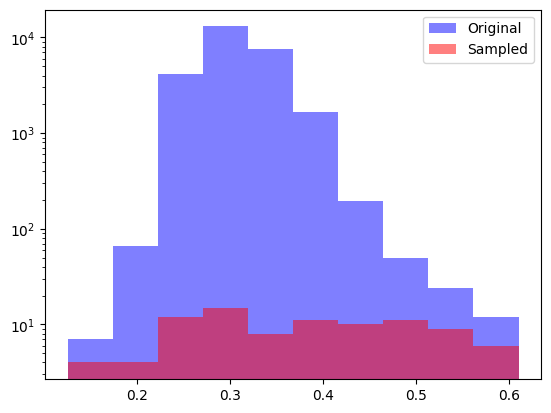

In [32]:
seq_cath_finetune_all_purge_7bny_noise_045_aln_df = pd.read_csv(Path.home() / "proteina/inference/inference_seq_cath_cond_sampling_finetune-all_21-seq_purge-7bny_045-noise/7bny_A/aln.tsv", sep="\t")
tms = seq_cath_finetune_all_purge_7bny_noise_045_aln_df["TM1"]
# Bin the TMS values into 10 bins from min to max values, and draw at most 10 examples in each bin
# by extracting the pandas dataframe index of the TMS values in each bin
min_tms = min(tms)
max_tms = max(tms)
bin_width = (max_tms - min_tms) / 10
bins = [min_tms + i * bin_width for i in range(10)]
# Count the number of TMS values in each bin
counts = [0] * 10
binned_indices = [[] for _ in range(10)]
for i, tm in enumerate(tms):
    bin_index = int((tm - min_tms) // bin_width) - 1
    binned_indices[bin_index].append(i)
    counts[bin_index] += 1

if not os.path.exists(Path.home() / "proteina/inference/inference_seq_cath_cond_sampling_finetune-all_21-seq_purge-7bny_045-noise/7bny_A/sampled_files.txt"):
    sampled_indices = []
    sampled_files = []
    sampled_tms = []
    # Draw 10 examples in each bin
    for i in range(10):
        if counts[i] > 0:
            sampled_indices.append(np.random.choice(binned_indices[i], size=min(10, counts[i]), replace=False))
            sampled_tms.extend(tms[sampled_indices[i]])
            in_files = seq_cath_finetune_all_purge_7bny_noise_045_aln_df.iloc[sampled_indices[i]]["PDBchain2"].str.split("/").str[-1].str.split(":").str[0].tolist()
            out_files = [file.replace(".pdb", ".rebuilt.pdb") for file in in_files]
            for in_file, out_file in zip(in_files, out_files):
                result = subprocess.run(["pulchra", str(Path.home() / "proteina/inference/inference_seq_cath_cond_sampling_finetune-all_21-seq_purge-7bny_045-noise/7bny_A" / in_file)], capture_output=True, text=True, check=True)
                if result.returncode != 0:
                    raise Exception(f"Error: {result.stderr}")
                # Parse the output file and rename the chain to chain A
                new_lines = []
                with open(Path.home() / "proteina/inference/inference_seq_cath_cond_sampling_finetune-all_21-seq_purge-7bny_045-noise/7bny_A" / out_file, "r") as f:
                    for line in f.readlines():
                        if line.startswith("ATOM"):
                            new_lines.append(line[:21] + "A" + line[22:-1] + "  1.00  0.00           C  " + "\n")
                        else:
                            new_lines.append(line)
                # Overwrite the output file
                with open(Path.home() / "proteina/inference/inference_seq_cath_cond_sampling_finetune-all_21-seq_purge-7bny_045-noise/7bny_A" / out_file, "w") as f:
                    for line in new_lines:
                        f.write(line)
            sampled_files.extend(out_files)

    # Save sampled_files to a text file
    with open(Path.home() / "proteina/inference/inference_seq_cath_cond_sampling_finetune-all_21-seq_purge-7bny_045-noise/7bny_A/sampled_files.txt", "w") as f:
        for file in sampled_files:
            f.write(file + "\n")
else:
    with open(Path.home() / "proteina/inference/inference_seq_cath_cond_sampling_finetune-all_21-seq_purge-7bny_045-noise/7bny_A/sampled_files.txt", "r") as f:
        sampled_files = [line.strip() for line in f.readlines()]
    print(len(sampled_files))
    sampled_indices = []
    sampled_tms = []
    out_names = seq_cath_finetune_all_purge_7bny_noise_045_aln_df["PDBchain2"].str.split("/").str[-1].str.split(":").str[0]
    for file in sampled_files:
        sampled_indices.append(out_names[out_names == file].index[0])
        sampled_tms.append(tms[sampled_indices[-1]])

if not os.path.exists(Path.home() / "proteina/inference/inference_seq_cath_cond_sampling_finetune-all_21-seq_purge-7bny_045-noise/7bny_A/subset_data.csv"):
    # Save sampled_files to a csv called subset_data.csv with one column "description" to follow formatting with existing analysis code
    sampled_files_df = pd.DataFrame({"description": sampled_files})
    sampled_files_df["description"] = sampled_files_df["description"].str.replace(".pdb", "")
    sampled_files_df.to_csv(Path.home() / "proteina/inference/inference_seq_cath_cond_sampling_finetune-all_21-seq_purge-7bny_045-noise/7bny_A/subset_data.csv", index=False)

# Plot the histogram
plt.hist(tms, bins=np.arange(min_tms, max_tms+bin_width, bin_width), color="blue", alpha=0.5, label="Original")
plt.hist(sampled_tms, bins=np.arange(min_tms, max_tms+bin_width, bin_width), color="red", alpha=0.5, label="Sampled")
plt.yscale("log")
plt.legend()
plt.show()


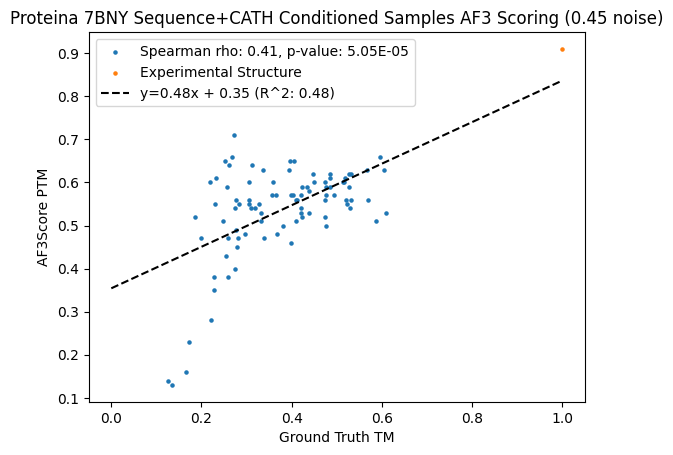

In [4]:
results_dir = Path.home() / "proteina/inference/inference_seq_cath_cond_sampling_finetune-all_21-seq_purge-7bny_045-noise/7bny_A/score_results"
seq_cath_finetune_all_purge_7bny_noise_045_aln_df = pd.read_csv(Path.home() / "proteina/inference/inference_seq_cath_cond_sampling_finetune-all_21-seq_purge-7bny_045-noise/7bny_A/aln.tsv", sep="\t")
seq_cath_finetune_all_purge_7bny_noise_045_aln_df["PDBchain2"] = seq_cath_finetune_all_purge_7bny_noise_045_aln_df["PDBchain2"].str.split(":").str[0].str.split("/").str[-1].str.replace(".pdb", "")

gt_score_results_path = Path.home() / "data/7bny_example/score_results/7bny_A_CA.rebuilt/seed-10_sample-0/summary_confidences.json"
with open(gt_score_results_path, "r") as f:
    gt_score_results = json.load(f)
    gt_ptm = gt_score_results["ptm"]

# Get all subdirectories in results_dir
subdirs = [d for d in results_dir.iterdir() if d.is_dir()]
ptm_list = []
tm_list = []

# For each subdirectory, read the score_results.json file
for subdir in subdirs:
    subdir_name = subdir.name
    tm_list.append(seq_cath_finetune_all_purge_7bny_noise_045_aln_df[seq_cath_finetune_all_purge_7bny_noise_045_aln_df["PDBchain2"] == subdir_name]["TM1"].values[0])
    score_results_path = subdir / "seed-10_sample-0/summary_confidences.json"
    if score_results_path.exists():
        with open(score_results_path, "r") as f:
            score_results = json.load(f)
            ptm_list.append(score_results["ptm"])

# Calculate the spearman correlation between ptm and tm and plot the line of best fit
spearman_rho = scipy.stats.spearmanr(tm_list, ptm_list).statistic
spearman_p = scipy.stats.spearmanr(tm_list, ptm_list).pvalue
linear_regression = np.polyfit(tm_list, ptm_list, 1)
linear_regression_line = np.poly1d(linear_regression)

# Plot the line of best fit
plt.scatter(tm_list, ptm_list, s=5, label=f"Spearman rho: {spearman_rho:.2f}, p-value: {spearman_p:.2E}")
plt.scatter([1], gt_ptm, s=5, label="Experimental Structure")
plt.plot([0, 1], linear_regression_line([0, 1]), linestyle="--", color="black", label=f"y={linear_regression[0]:.2f}x + {linear_regression[1]:.2f} (R^2: {linear_regression[0]:.2f})")
plt.legend()
plt.xlabel("Ground Truth TM")
plt.ylabel("AF3Score PTM")
plt.title("Proteina 7BNY Sequence+CATH Conditioned Samples AF3 Scoring (0.45 noise)")
plt.show()


90
7bny_A_cath_4.10.49.10_7.rebuilt.pdb TM: 0.6278


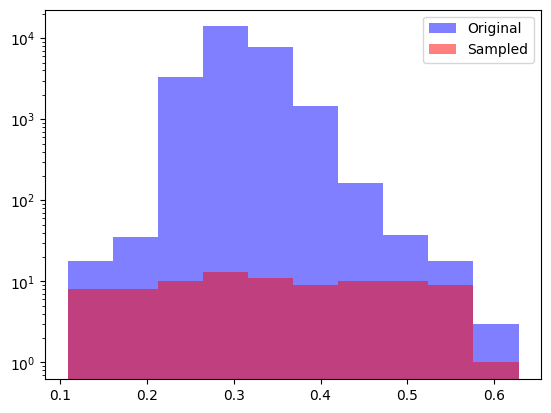

In [41]:
seq_cath_finetune_all_purge_7bny_noise_060_aln_df = pd.read_csv(Path.home() / "proteina/inference/inference_seq_cath_cond_sampling_finetune-all_21-seq_purge-7bny_060-noise/7bny_A/aln.tsv", sep="\t")
tms = seq_cath_finetune_all_purge_7bny_noise_060_aln_df["TM1"]
# Bin the TMS values into 10 bins from min to max values, and draw at most 10 examples in each bin
# by extracting the pandas dataframe index of the TMS values in each bin
min_tms = min(tms)
max_tms = max(tms)
bin_width = (max_tms - min_tms) / 10
bins = [min_tms + i * bin_width for i in range(10)]
# Count the number of TMS values in each bin
counts = [0] * 10
binned_indices = [[] for _ in range(10)]
for i, tm in enumerate(tms):
    bin_index = int((tm - min_tms) // bin_width) - 1
    binned_indices[bin_index].append(i)
    counts[bin_index] += 1

if not os.path.exists(Path.home() / "proteina/inference/inference_seq_cath_cond_sampling_finetune-all_21-seq_purge-7bny_060-noise/7bny_A/sampled_files.txt"):
    sampled_indices = []
    sampled_files = []
    sampled_tms = []
    # Draw 10 examples in each bin
    for i in range(10):
        if counts[i] > 0:
            sampled_indices.append(np.random.choice(binned_indices[i], size=min(10, counts[i]), replace=False))
            sampled_tms.extend(tms[sampled_indices[i]])
            in_files = seq_cath_finetune_all_purge_7bny_noise_060_aln_df.iloc[sampled_indices[i]]["PDBchain2"].str.split("/").str[-1].str.split(":").str[0].tolist()
            out_files = [file.replace(".pdb", ".rebuilt.pdb") for file in in_files]
            for in_file, out_file in zip(in_files, out_files):
                result = subprocess.run(["pulchra", str(Path.home() / "proteina/inference/inference_seq_cath_cond_sampling_finetune-all_21-seq_purge-7bny_060-noise/7bny_A" / in_file)], capture_output=True, text=True, check=True)
                if result.returncode != 0:
                    raise Exception(f"Error: {result.stderr}")
                # Parse the output file and rename the chain to chain A
                new_lines = []
                with open(Path.home() / "proteina/inference/inference_seq_cath_cond_sampling_finetune-all_21-seq_purge-7bny_060-noise/7bny_A" / out_file, "r") as f:
                    for line in f.readlines():
                        if line.startswith("ATOM"):
                            new_lines.append(line[:21] + "A" + line[22:-1] + "  1.00  0.00           C  " + "\n")
                        else:
                            new_lines.append(line)
                # Overwrite the output file
                with open(Path.home() / "proteina/inference/inference_seq_cath_cond_sampling_finetune-all_21-seq_purge-7bny_060-noise/7bny_A" / out_file, "w") as f:
                    for line in new_lines:
                        f.write(line)
            sampled_files.extend(out_files)

    # Save sampled_files to a text file
    with open(Path.home() / "proteina/inference/inference_seq_cath_cond_sampling_finetune-all_21-seq_purge-7bny_060-noise/7bny_A/sampled_files.txt", "w") as f:
        for file in sampled_files:
            f.write(file + "\n")
else:
    with open(Path.home() / "proteina/inference/inference_seq_cath_cond_sampling_finetune-all_21-seq_purge-7bny_060-noise/7bny_A/sampled_files.txt", "r") as f:
        sampled_files = [line.strip() for line in f.readlines()]
    print(len(sampled_files))
    sampled_indices = []
    sampled_tms = []
    out_names = seq_cath_finetune_all_purge_7bny_noise_060_aln_df["PDBchain2"].str.split("/").str[-1].str.split(":").str[0]
    for file in sampled_files:
        sampled_indices.append(out_names[out_names == file].index[0])
        sampled_tms.append(tms[sampled_indices[-1]])

print(sampled_files[sampled_tms.index(max(sampled_tms))] + " TM: " + str(max(sampled_tms)))

if not os.path.exists(Path.home() / "proteina/inference/inference_seq_cath_cond_sampling_finetune-all_21-seq_purge-7bny_060-noise/7bny_A/subset_data.csv"):
    # Save sampled_files to a csv called subset_data.csv with one column "description" to follow formatting with existing analysis code
    sampled_files_df = pd.DataFrame({"description": sampled_files})
    sampled_files_df["description"] = sampled_files_df["description"].str.replace(".pdb", "")
    sampled_files_df.to_csv(Path.home() / "proteina/inference/inference_seq_cath_cond_sampling_finetune-all_21-seq_purge-7bny_060-noise/7bny_A/subset_data.csv", index=False)

# Plot the histogram
plt.hist(tms, bins=np.arange(min_tms, max_tms+bin_width, bin_width), color="blue", alpha=0.5, label="Original")
plt.hist(sampled_tms, bins=np.arange(min_tms, max_tms+bin_width, bin_width), color="red", alpha=0.5, label="Sampled")
plt.yscale("log")
plt.legend()
plt.show()


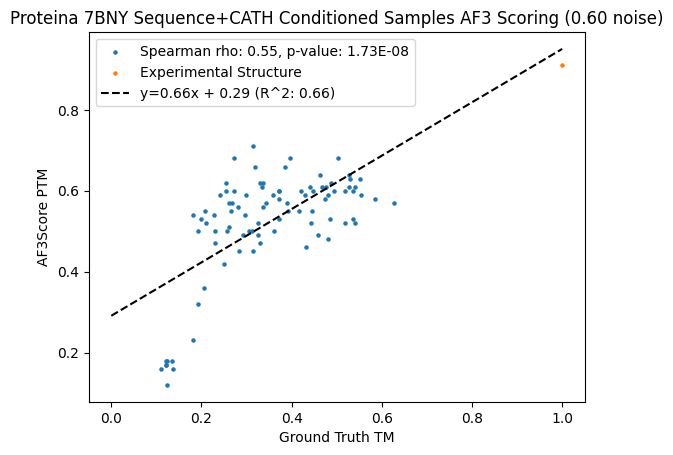

In [5]:
results_dir = Path.home() / "proteina/inference/inference_seq_cath_cond_sampling_finetune-all_21-seq_purge-7bny_060-noise/7bny_A/score_results"
seq_cath_finetune_all_purge_7bny_noise_060_aln_df = pd.read_csv(Path.home() / "proteina/inference/inference_seq_cath_cond_sampling_finetune-all_21-seq_purge-7bny_060-noise/7bny_A/aln.tsv", sep="\t")
seq_cath_finetune_all_purge_7bny_noise_060_aln_df["PDBchain2"] = seq_cath_finetune_all_purge_7bny_noise_060_aln_df["PDBchain2"].str.split(":").str[0].str.split("/").str[-1].str.replace(".pdb", "")

gt_score_results_path = Path.home() / "data/7bny_example/score_results/7bny_A_CA.rebuilt/seed-10_sample-0/summary_confidences.json"
with open(gt_score_results_path, "r") as f:
    gt_score_results = json.load(f)
    gt_ptm = gt_score_results["ptm"]

# Get all subdirectories in results_dir
subdirs = [d for d in results_dir.iterdir() if d.is_dir()]
ptm_list = []
tm_list = []

# For each subdirectory, read the score_results.json file
for subdir in subdirs:
    subdir_name = subdir.name
    tm_list.append(seq_cath_finetune_all_purge_7bny_noise_060_aln_df[seq_cath_finetune_all_purge_7bny_noise_060_aln_df["PDBchain2"] == subdir_name]["TM1"].values[0])
    score_results_path = subdir / "seed-10_sample-0/summary_confidences.json"
    if score_results_path.exists():
        with open(score_results_path, "r") as f:
            score_results = json.load(f)
            ptm_list.append(score_results["ptm"])

# Calculate the spearman correlation between ptm and tm and plot the line of best fit
spearman_rho = scipy.stats.spearmanr(tm_list, ptm_list).statistic
spearman_p = scipy.stats.spearmanr(tm_list, ptm_list).pvalue
linear_regression = np.polyfit(tm_list, ptm_list, 1)
linear_regression_line = np.poly1d(linear_regression)

# Plot the line of best fit
plt.scatter(tm_list, ptm_list, s=5, label=f"Spearman rho: {spearman_rho:.2f}, p-value: {spearman_p:.2E}")
plt.scatter([1], gt_ptm, s=5, label="Experimental Structure")
plt.plot([0, 1], linear_regression_line([0, 1]), linestyle="--", color="black", label=f"y={linear_regression[0]:.2f}x + {linear_regression[1]:.2f} (R^2: {linear_regression[0]:.2f})")
plt.legend()
plt.xlabel("Ground Truth TM")
plt.ylabel("AF3Score PTM")
plt.title("Proteina 7BNY Sequence+CATH Conditioned Samples AF3 Scoring (0.60 noise)")
plt.show()


86


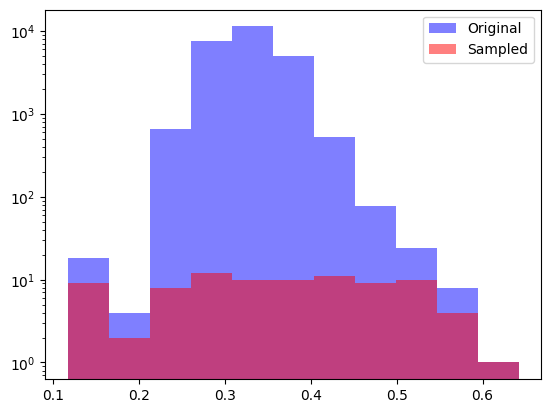

In [36]:
seq_finetune_all_purge_7bny_noise_045_aln_df = pd.read_csv(Path.home() / "proteina/inference/inference_seq_cond_sampling_finetune-all_21-seq_purge-7bny_045-noise/7bny_A/aln.tsv", sep="\t")
tms = seq_finetune_all_purge_7bny_noise_045_aln_df["TM1"]
# Bin the TMS values into 10 bins from min to max values, and draw at most 10 examples in each bin
# by extracting the pandas dataframe index of the TMS values in each bin
min_tms = min(tms)
max_tms = max(tms)
bin_width = (max_tms - min_tms) / 10
bins = [min_tms + i * bin_width for i in range(10)]
# Count the number of TMS values in each bin
counts = [0] * 10
binned_indices = [[] for _ in range(10)]
for i, tm in enumerate(tms):
    bin_index = int((tm - min_tms) // bin_width) - 1
    binned_indices[bin_index].append(i)
    counts[bin_index] += 1

if not os.path.exists(Path.home() / "proteina/inference/inference_seq_cond_sampling_finetune-all_21-seq_purge-7bny_045-noise/7bny_A/sampled_files.txt"):
    sampled_indices = []
    sampled_files = []
    sampled_tms = []
    # Draw 10 examples in each bin
    for i in range(10):
        if counts[i] > 0:
            sampled_indices.append(np.random.choice(binned_indices[i], size=min(10, counts[i]), replace=False))
            sampled_tms.extend(tms[sampled_indices[i]])
            in_files = seq_finetune_all_purge_7bny_noise_045_aln_df.iloc[sampled_indices[i]]["PDBchain2"].str.split("/").str[-1].str.split(":").str[0].tolist()
            out_files = [file.replace(".pdb", ".rebuilt.pdb") for file in in_files]
            for in_file, out_file in zip(in_files, out_files):
                result = subprocess.run(["pulchra", str(Path.home() / "proteina/inference/inference_seq_cond_sampling_finetune-all_21-seq_purge-7bny_045-noise/7bny_A" / in_file)], capture_output=True, text=True, check=True)
                if result.returncode != 0:
                    raise Exception(f"Error: {result.stderr}")
                # Parse the output file and rename the chain to chain A
                new_lines = []
                with open(Path.home() / "proteina/inference/inference_seq_cond_sampling_finetune-all_21-seq_purge-7bny_045-noise/7bny_A" / out_file, "r") as f:
                    for line in f.readlines():
                        if line.startswith("ATOM"):
                            new_lines.append(line[:21] + "A" + line[22:-1] + "  1.00  0.00           C  " + "\n")
                        else:
                            new_lines.append(line)
                # Overwrite the output file
                with open(Path.home() / "proteina/inference/inference_seq_cond_sampling_finetune-all_21-seq_purge-7bny_045-noise/7bny_A" / out_file, "w") as f:
                    for line in new_lines:
                        f.write(line)
            sampled_files.extend(out_files)

    # Save sampled_files to a text file
    with open(Path.home() / "proteina/inference/inference_seq_cond_sampling_finetune-all_21-seq_purge-7bny_045-noise/7bny_A/sampled_files.txt", "w") as f:
        for file in sampled_files:
            f.write(file + "\n")
else:
    with open(Path.home() / "proteina/inference/inference_seq_cond_sampling_finetune-all_21-seq_purge-7bny_045-noise/7bny_A/sampled_files.txt", "r") as f:
        sampled_files = [line.strip() for line in f.readlines()]
    print(len(sampled_files))
    sampled_indices = []
    sampled_tms = []
    out_names = seq_finetune_all_purge_7bny_noise_045_aln_df["PDBchain2"].str.split("/").str[-1].str.split(":").str[0]
    for file in sampled_files:
        sampled_indices.append(out_names[out_names == file].index[0])
        sampled_tms.append(tms[sampled_indices[-1]])

if not os.path.exists(Path.home() / "proteina/inference/inference_seq_cond_sampling_finetune-all_21-seq_purge-7bny_045-noise/7bny_A/subset_data.csv"):
    # Save sampled_files to a csv called subset_data.csv with one column "description" to follow formatting with existing analysis code
    sampled_files_df = pd.DataFrame({"description": sampled_files})
    sampled_files_df["description"] = sampled_files_df["description"].str.replace(".pdb", "")
    sampled_files_df.to_csv(Path.home() / "proteina/inference/inference_seq_cond_sampling_finetune-all_21-seq_purge-7bny_045-noise/7bny_A/subset_data.csv", index=False)

# Plot the histogram
plt.hist(tms, bins=np.arange(min_tms, max_tms+bin_width, bin_width), color="blue", alpha=0.5, label="Original")
plt.hist(sampled_tms, bins=np.arange(min_tms, max_tms+bin_width, bin_width), color="red", alpha=0.5, label="Sampled")
plt.yscale("log")
plt.legend()
plt.show()

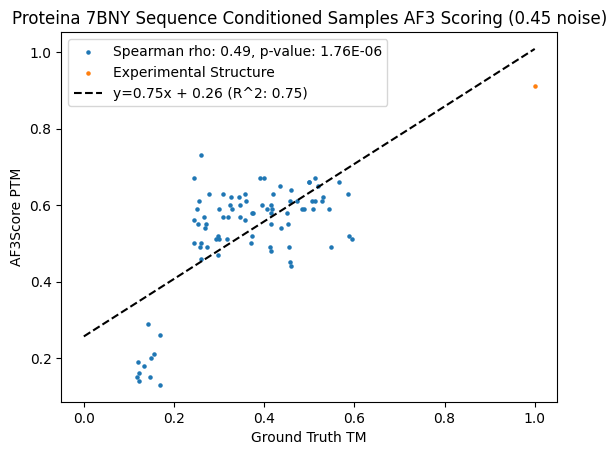

In [6]:
results_dir = Path.home() / "proteina/inference/inference_seq_cond_sampling_finetune-all_21-seq_purge-7bny_045-noise/7bny_A/score_results"
seq_finetune_all_purge_7bny_noise_045_aln_df = pd.read_csv(Path.home() / "proteina/inference/inference_seq_cond_sampling_finetune-all_21-seq_purge-7bny_045-noise/7bny_A/aln.tsv", sep="\t")
seq_finetune_all_purge_7bny_noise_045_aln_df["PDBchain2"] = seq_finetune_all_purge_7bny_noise_045_aln_df["PDBchain2"].str.split(":").str[0].str.split("/").str[-1].str.replace(".pdb", "")

gt_score_results_path = Path.home() / "data/7bny_example/score_results/7bny_A_CA.rebuilt/seed-10_sample-0/summary_confidences.json"
with open(gt_score_results_path, "r") as f:
    gt_score_results = json.load(f)
    gt_ptm = gt_score_results["ptm"]

# Get all subdirectories in results_dir
subdirs = [d for d in results_dir.iterdir() if d.is_dir()]
ptm_list = []
tm_list = []

# For each subdirectory, read the score_results.json file
for subdir in subdirs:
    subdir_name = subdir.name
    tm_list.append(seq_finetune_all_purge_7bny_noise_045_aln_df[seq_finetune_all_purge_7bny_noise_045_aln_df["PDBchain2"] == subdir_name]["TM1"].values[0])
    score_results_path = subdir / "seed-10_sample-0/summary_confidences.json"
    if score_results_path.exists():
        with open(score_results_path, "r") as f:
            score_results = json.load(f)
            ptm_list.append(score_results["ptm"])

# Calculate the spearman correlation between ptm and tm and plot the line of best fit
spearman_rho = scipy.stats.spearmanr(tm_list, ptm_list).statistic
spearman_p = scipy.stats.spearmanr(tm_list, ptm_list).pvalue
linear_regression = np.polyfit(tm_list, ptm_list, 1)
linear_regression_line = np.poly1d(linear_regression)

# Plot the line of best fit
plt.scatter(tm_list, ptm_list, s=5, label=f"Spearman rho: {spearman_rho:.2f}, p-value: {spearman_p:.2E}")
plt.scatter([1], gt_ptm, s=5, label="Experimental Structure")
plt.plot([0, 1], linear_regression_line([0, 1]), linestyle="--", color="black", label=f"y={linear_regression[0]:.2f}x + {linear_regression[1]:.2f} (R^2: {linear_regression[0]:.2f})")
plt.legend()
plt.xlabel("Ground Truth TM")
plt.ylabel("AF3Score PTM")
plt.title("Proteina 7BNY Sequence Conditioned Samples AF3 Scoring (0.45 noise)")
plt.show()


86


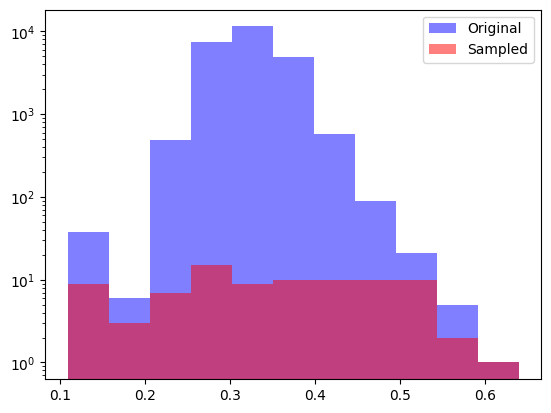

In [38]:
seq_finetune_all_purge_7bny_noise_060_aln_df = pd.read_csv(Path.home() / "proteina/inference/inference_seq_cond_sampling_finetune-all_21-seq_purge-7bny_060-noise/7bny_A/aln.tsv", sep="\t")
tms = seq_finetune_all_purge_7bny_noise_060_aln_df["TM1"]
# Bin the TMS values into 10 bins from min to max values, and draw at most 10 examples in each bin
# by extracting the pandas dataframe index of the TMS values in each bin
min_tms = min(tms)
max_tms = max(tms)
bin_width = (max_tms - min_tms) / 10
bins = [min_tms + i * bin_width for i in range(10)]
# Count the number of TMS values in each bin
counts = [0] * 10
binned_indices = [[] for _ in range(10)]
for i, tm in enumerate(tms):
    bin_index = int((tm - min_tms) // bin_width) - 1
    binned_indices[bin_index].append(i)
    counts[bin_index] += 1

if not os.path.exists(Path.home() / "proteina/inference/inference_seq_cond_sampling_finetune-all_21-seq_purge-7bny_060-noise/7bny_A/sampled_files.txt"):
    sampled_indices = []
    sampled_files = []
    sampled_tms = []
    # Draw 10 examples in each bin
    for i in range(10):
        if counts[i] > 0:
            sampled_indices.append(np.random.choice(binned_indices[i], size=min(10, counts[i]), replace=False))
            sampled_tms.extend(tms[sampled_indices[i]])
            in_files = seq_finetune_all_purge_7bny_noise_060_aln_df.iloc[sampled_indices[i]]["PDBchain2"].str.split("/").str[-1].str.split(":").str[0].tolist()
            out_files = [file.replace(".pdb", ".rebuilt.pdb") for file in in_files]
            for in_file, out_file in zip(in_files, out_files):
                result = subprocess.run(["pulchra", str(Path.home() / "proteina/inference/inference_seq_cond_sampling_finetune-all_21-seq_purge-7bny_060-noise/7bny_A" / in_file)], capture_output=True, text=True, check=True)
                if result.returncode != 0:
                    raise Exception(f"Error: {result.stderr}")
                # Parse the output file and rename the chain to chain A
                new_lines = []
                with open(Path.home() / "proteina/inference/inference_seq_cond_sampling_finetune-all_21-seq_purge-7bny_060-noise/7bny_A" / out_file, "r") as f:
                    for line in f.readlines():
                        if line.startswith("ATOM"):
                            new_lines.append(line[:21] + "A" + line[22:-1] + "  1.00  0.00           C  " + "\n")
                        else:
                            new_lines.append(line)
                # Overwrite the output file
                with open(Path.home() / "proteina/inference/inference_seq_cond_sampling_finetune-all_21-seq_purge-7bny_060-noise/7bny_A" / out_file, "w") as f:
                    for line in new_lines:
                        f.write(line)
            sampled_files.extend(out_files)

    # Save sampled_files to a text file
    with open(Path.home() / "proteina/inference/inference_seq_cond_sampling_finetune-all_21-seq_purge-7bny_060-noise/7bny_A/sampled_files.txt", "w") as f:
        for file in sampled_files:
            f.write(file + "\n")
else:
    with open(Path.home() / "proteina/inference/inference_seq_cond_sampling_finetune-all_21-seq_purge-7bny_060-noise/7bny_A/sampled_files.txt", "r") as f:
        sampled_files = [line.strip() for line in f.readlines()]
    print(len(sampled_files))
    sampled_indices = []
    sampled_tms = []
    out_names = seq_finetune_all_purge_7bny_noise_060_aln_df["PDBchain2"].str.split("/").str[-1].str.split(":").str[0]
    for file in sampled_files:
        sampled_indices.append(out_names[out_names == file].index[0])
        sampled_tms.append(tms[sampled_indices[-1]])

if not os.path.exists(Path.home() / "proteina/inference/inference_seq_cond_sampling_finetune-all_21-seq_purge-7bny_060-noise/7bny_A/subset_data.csv"):
    # Save sampled_files to a csv called subset_data.csv with one column "description" to follow formatting with existing analysis code
    sampled_files_df = pd.DataFrame({"description": sampled_files})
    sampled_files_df["description"] = sampled_files_df["description"].str.replace(".pdb", "")
    sampled_files_df.to_csv(Path.home() / "proteina/inference/inference_seq_cond_sampling_finetune-all_21-seq_purge-7bny_060-noise/7bny_A/subset_data.csv", index=False)

# Plot the histogram
plt.hist(tms, bins=np.arange(min_tms, max_tms+bin_width, bin_width), color="blue", alpha=0.5, label="Original")
plt.hist(sampled_tms, bins=np.arange(min_tms, max_tms+bin_width, bin_width), color="red", alpha=0.5, label="Sampled")
plt.yscale("log")
plt.legend()
plt.show()

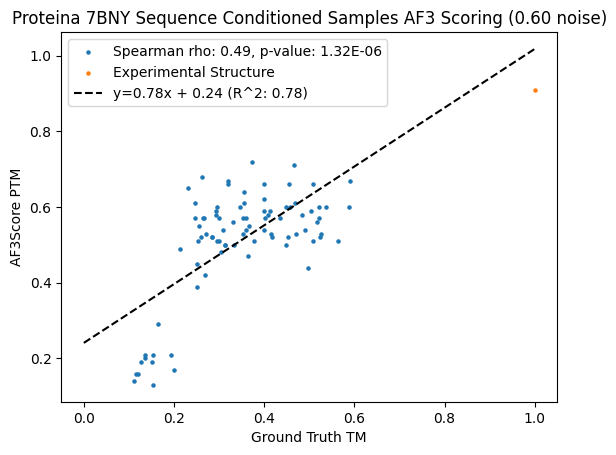

In [7]:
results_dir = Path.home() / "proteina/inference/inference_seq_cond_sampling_finetune-all_21-seq_purge-7bny_060-noise/7bny_A/score_results"
seq_finetune_all_purge_7bny_noise_060_aln_df = pd.read_csv(Path.home() / "proteina/inference/inference_seq_cond_sampling_finetune-all_21-seq_purge-7bny_060-noise/7bny_A/aln.tsv", sep="\t")
seq_finetune_all_purge_7bny_noise_060_aln_df["PDBchain2"] = seq_finetune_all_purge_7bny_noise_060_aln_df["PDBchain2"].str.split(":").str[0].str.split("/").str[-1].str.replace(".pdb", "")

gt_score_results_path = Path.home() / "data/7bny_example/score_results/7bny_A_CA.rebuilt/seed-10_sample-0/summary_confidences.json"
with open(gt_score_results_path, "r") as f:
    gt_score_results = json.load(f)
    gt_ptm = gt_score_results["ptm"]

# Get all subdirectories in results_dir
subdirs = [d for d in results_dir.iterdir() if d.is_dir()]
ptm_list = []
tm_list = []

# For each subdirectory, read the score_results.json file
for subdir in subdirs:
    subdir_name = subdir.name
    tm_list.append(seq_finetune_all_purge_7bny_noise_060_aln_df[seq_finetune_all_purge_7bny_noise_060_aln_df["PDBchain2"] == subdir_name]["TM1"].values[0])
    score_results_path = subdir / "seed-10_sample-0/summary_confidences.json"
    if score_results_path.exists():
        with open(score_results_path, "r") as f:
            score_results = json.load(f)
            ptm_list.append(score_results["ptm"])

# Calculate the spearman correlation between ptm and tm and plot the line of best fit
spearman_rho = scipy.stats.spearmanr(tm_list, ptm_list).statistic
spearman_p = scipy.stats.spearmanr(tm_list, ptm_list).pvalue
linear_regression = np.polyfit(tm_list, ptm_list, 1)
linear_regression_line = np.poly1d(linear_regression)

# Plot the line of best fit
plt.scatter(tm_list, ptm_list, s=5, label=f"Spearman rho: {spearman_rho:.2f}, p-value: {spearman_p:.2E}")
plt.scatter([1], gt_ptm, s=5, label="Experimental Structure")
plt.plot([0, 1], linear_regression_line([0, 1]), linestyle="--", color="black", label=f"y={linear_regression[0]:.2f}x + {linear_regression[1]:.2f} (R^2: {linear_regression[0]:.2f})")
plt.legend()
plt.xlabel("Ground Truth TM")
plt.ylabel("AF3Score PTM")
plt.title("Proteina 7BNY Sequence Conditioned Samples AF3 Scoring (0.60 noise)")
plt.show()


In [ ]:
results_dir = Path.home() / "proteina/inference/inference_seq_cath_cond_sampling_finetune-all_21-seq_purge-7bny_045-noise/7bny_A/score_results"
seq_cath_finetune_all_purge_7bny_noise_045_aln_df = pd.read_csv(Path.home() / "proteina/inference/inference_seq_cath_cond_sampling_finetune-all_21-seq_purge-7bny_045-noise/7bny_A/aln.tsv", sep="\t")
seq_cath_finetune_all_purge_7bny_noise_045_aln_df["PDBchain2"] = seq_cath_finetune_all_purge_7bny_noise_045_aln_df["PDBchain2"].str.split(":").str[0].str.split("/").str[-1].str.replace(".pdb", "")

# Get all subdirectories in results_dir
subdirs = [d for d in results_dir.iterdir() if d.is_dir()]
ptm_list = []
tm_list = []

# For each subdirectory, read the score_results.json file
for subdir in subdirs:
    subdir_name = subdir.name
    tm_list.append(seq_cath_finetune_all_purge_7bny_noise_045_aln_df[seq_cath_finetune_all_purge_7bny_noise_045_aln_df["PDBchain2"] == subdir_name]["TM1"].values[0])
    score_results_path = subdir / "seed-10_sample-0/summary_confidences.json"
    if score_results_path.exists():
        with open(score_results_path, "r") as f:
            score_results = json.load(f)
            ptm_list.append(score_results["ptm"])

# Calculate the spearman correlation between ptm and tm and plot the line of best fit
spearman_correlation = scipy.stats.spearmanr(tm_list, ptm_list).statistic
linear_regression = np.polyfit(tm_list, ptm_list, 1)
linear_regression_line = np.poly1d(linear_regression)

# Plot the line of best fit
plt.scatter(tm_list, ptm_list, s=5, label=f"spearman rho: {spearman_correlation:.2f}")
plt.plot(np.unique(tm_list), linear_regression_line(np.unique(tm_list)), color="black", label=f"y={linear_regression[0]:.2f}x + {linear_regression[1]:.2f} (R^2: {linear_regression[0]:.2f})")
plt.legend()
plt.xlabel("Ground Truth TM")
plt.ylabel("AF3Score PTM")
plt.title("Proteina 7BNY Samples AF3 Scoring")
plt.show()


In [ ]:
seq_cath_lora_r8_aln_df = pd.read_csv(Path.home() / "proteina/inference/inference_seq_cath_cond_sampling_21-seq_lora-r8/4jnj_A/aln.tsv", sep="\t")
seq_cath_aln_df = pd.read_csv(Path.home() / "proteina/inference/inference_seq_cath_cond_sampling_21-seq/4jnj_A/aln.tsv", sep="\t")
seq_aln_df = pd.read_csv(Path.home() / "proteina/inference/inference_seq_cond_sampling_21-seq/4jnj_A/aln.tsv", sep="\t")
seq_lora_r8_aln_df = pd.read_csv(Path.home() / "proteina/inference/inference_seq_cond_sampling_21-seq_lora-r8/4jnj_A/aln.tsv", sep="\t")
seq_lora_r4_aln_df = pd.read_csv(Path.home() / "proteina/inference/inference_seq_cond_sampling_21-seq_lora-r4/4jnj_A/aln.tsv", sep="\t")
seq_lora_r2_aln_df = pd.read_csv(Path.home() / "proteina/inference/inference_seq_cond_sampling_21-seq_lora-r2/4jnj_A/aln.tsv", sep="\t")


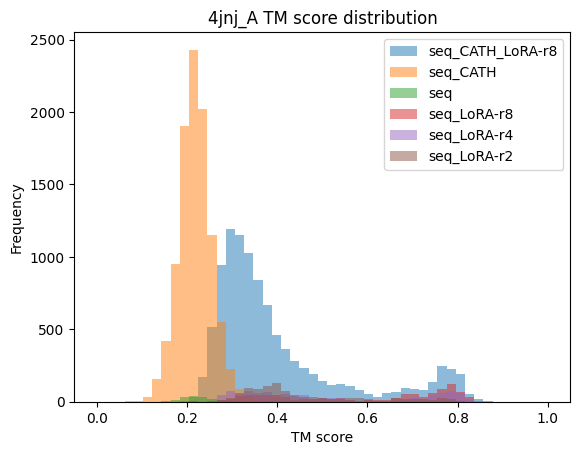

In [ ]:
plt.hist(seq_cath_lora_r8_aln_df["TM1"].to_numpy(), alpha=0.5, bins=np.linspace(0, 1, 50), label="seq_CATH_LoRA-r8")
plt.hist(seq_cath_aln_df["TM1"].to_numpy(), alpha=0.5, bins=np.linspace(0, 1, 50), label="seq_CATH")
plt.hist(seq_aln_df["TM1"].to_numpy(), alpha=0.5, bins=np.linspace(0, 1, 50), label="seq")
plt.hist(seq_lora_r8_aln_df["TM1"].to_numpy(), alpha=0.5, bins=np.linspace(0, 1, 50), label="seq_LoRA-r8")
plt.hist(seq_lora_r4_aln_df["TM1"].to_numpy(), alpha=0.5, bins=np.linspace(0, 1, 50), label="seq_LoRA-r4")
plt.hist(seq_lora_r2_aln_df["TM1"].to_numpy(), alpha=0.5, bins=np.linspace(0, 1, 50), label="seq_LoRA-r2")
plt.xlabel("TM score")
plt.ylabel("Frequency")
plt.title("4jnj_A TM score distribution")
plt.legend()
plt.show()


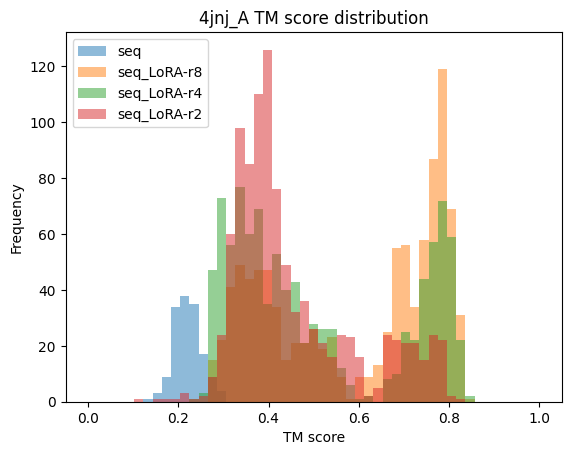

In [4]:
plt.hist(seq_aln_df["TM1"].to_numpy(), alpha=0.5, bins=np.linspace(0, 1, 50), label="seq")
plt.hist(seq_lora_r8_aln_df["TM1"].to_numpy(), alpha=0.5, bins=np.linspace(0, 1, 50), label="seq_LoRA-r8")
plt.hist(seq_lora_r4_aln_df["TM1"].to_numpy(), alpha=0.5, bins=np.linspace(0, 1, 50), label="seq_LoRA-r4")
plt.hist(seq_lora_r2_aln_df["TM1"].to_numpy(), alpha=0.5, bins=np.linspace(0, 1, 50), label="seq_LoRA-r2")
plt.xlabel("TM score")
plt.ylabel("Frequency")
plt.title("4jnj_A TM score distribution")
plt.legend()
plt.show()

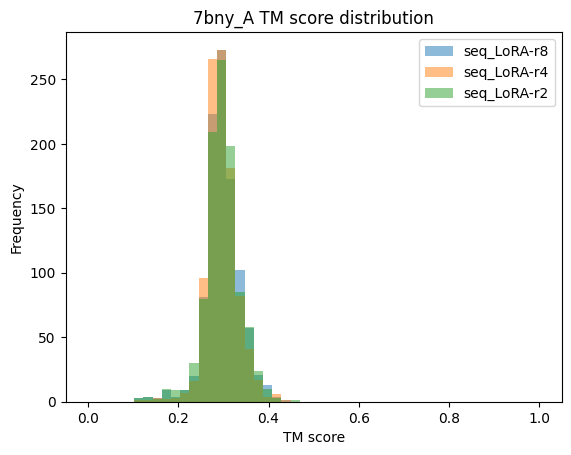

In [3]:
seq_lora_r8_purge_7bny_aln_df = pd.read_csv(Path.home() / "proteina/inference/inference_seq_cond_sampling_21-seq_lora-r8_purge-7bny/7bny_A/aln.tsv", sep="\t")
seq_lora_r4_purge_7bny_aln_df = pd.read_csv(Path.home() / "proteina/inference/inference_seq_cond_sampling_21-seq_lora-r4_purge-7bny/7bny_A/aln.tsv", sep="\t")
seq_lora_r2_purge_7bny_aln_df = pd.read_csv(Path.home() / "proteina/inference/inference_seq_cond_sampling_21-seq_lora-r2_purge-7bny/7bny_A/aln.tsv", sep="\t")

plt.hist(seq_lora_r8_purge_7bny_aln_df["TM1"].to_numpy(), alpha=0.5, bins=np.linspace(0, 1, 50), label="seq_LoRA-r8")
plt.hist(seq_lora_r4_purge_7bny_aln_df["TM1"].to_numpy(), alpha=0.5, bins=np.linspace(0, 1, 50), label="seq_LoRA-r4")
plt.hist(seq_lora_r2_purge_7bny_aln_df["TM1"].to_numpy(), alpha=0.5, bins=np.linspace(0, 1, 50), label="seq_LoRA-r2")
plt.xlabel("TM score")
plt.ylabel("Frequency")
plt.title("7bny_A TM score distribution")
plt.legend()
plt.show()


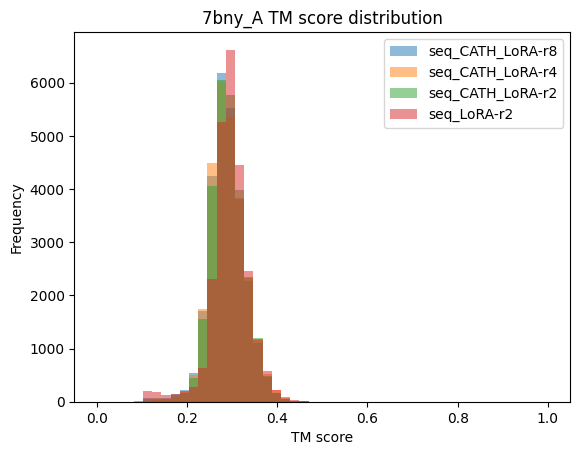

In [3]:
seq_cath_lora_r8_purge_7bny_aln_df = pd.read_csv(Path.home() / "proteina/inference/inference_seq_cath_cond_sampling_21-seq_lora-r8_purge-7bny/7bny_A/aln.tsv", sep="\t")
seq_cath_lora_r4_purge_7bny_aln_df = pd.read_csv(Path.home() / "proteina/inference/inference_seq_cath_cond_sampling_21-seq_lora-r4_purge-7bny/7bny_A/aln.tsv", sep="\t")
seq_cath_lora_r2_purge_7bny_aln_df = pd.read_csv(Path.home() / "proteina/inference/inference_seq_cath_cond_sampling_21-seq_lora-r2_purge-7bny/7bny_A/aln.tsv", sep="\t")
seq_lora_r2_purge_7bny_aln_df = pd.read_csv(Path.home() / "proteina/inference/inference_seq_cond_sampling_21-seq_lora-r2_purge-7bny/7bny_A/aln.tsv", sep="\t")

plt.hist(seq_cath_lora_r8_purge_7bny_aln_df["TM1"].to_numpy(), alpha=0.5, bins=np.linspace(0, 1, 50), label="seq_CATH_LoRA-r8")
plt.hist(seq_cath_lora_r4_purge_7bny_aln_df["TM1"].to_numpy(), alpha=0.5, bins=np.linspace(0, 1, 50), label="seq_CATH_LoRA-r4")
plt.hist(seq_cath_lora_r2_purge_7bny_aln_df["TM1"].to_numpy(), alpha=0.5, bins=np.linspace(0, 1, 50), label="seq_CATH_LoRA-r2")
plt.hist(seq_lora_r2_purge_7bny_aln_df["TM1"].to_numpy(), alpha=0.5, bins=np.linspace(0, 1, 50), label="seq_LoRA-r2")
plt.xlabel("TM score")
plt.ylabel("Frequency")
plt.title("7bny_A TM score distribution")
plt.legend()
plt.show()


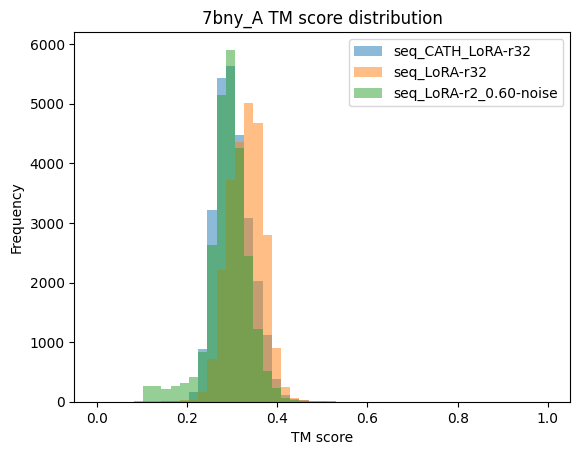

In [9]:
seq_cath_lora_r32_purge_7bny_aln_df = pd.read_csv(Path.home() / "proteina/inference/inference_seq_cath_cond_sampling_21-seq_lora-r32_purge-7bny/7bny_A/aln.tsv", sep="\t")
seq_lora_r32_purge_7bny_aln_df = pd.read_csv(Path.home() / "proteina/inference/inference_seq_cond_sampling_21-seq_lora-r32_purge-7bny/7bny_A/aln.tsv", sep="\t")
seq_lora_r2_purge_7bny_060_noise_aln_df = pd.read_csv(Path.home() / "proteina/inference/inference_seq_cond_sampling_21-seq_lora-r2_purge-7bny_060-noise/7bny_A/aln.tsv", sep="\t")


plt.hist(seq_cath_lora_r32_purge_7bny_aln_df["TM1"].to_numpy(), alpha=0.5, bins=np.linspace(0, 1, 50), label="seq_CATH_LoRA-r32")
plt.hist(seq_lora_r32_purge_7bny_aln_df["TM1"].to_numpy(), alpha=0.5, bins=np.linspace(0, 1, 50), label="seq_LoRA-r32")
plt.hist(seq_lora_r2_purge_7bny_060_noise_aln_df["TM1"].to_numpy(), alpha=0.5, bins=np.linspace(0, 1, 50), label="seq_LoRA-r2_0.60-noise")
plt.xlabel("TM score")
plt.ylabel("Frequency")
plt.title("7bny_A TM score distribution")
plt.legend()
plt.show()


In [10]:
print(seq_cath_lora_r32_purge_7bny_aln_df.sort_values(by="TM1", ascending=False).head(3)["TM1"])
print(seq_lora_r32_purge_7bny_aln_df.sort_values(by="TM1", ascending=False).head(3)["TM1"])
print(seq_lora_r2_purge_7bny_060_noise_aln_df.sort_values(by="TM1", ascending=False).head(3)["TM1"])


15634    0.5583
10919    0.5446
24101    0.5412
Name: TM1, dtype: float64
18365    0.5080
7714     0.5069
7199     0.5017
Name: TM1, dtype: float64
7070     0.5008
24215    0.4954
5058     0.4729
Name: TM1, dtype: float64


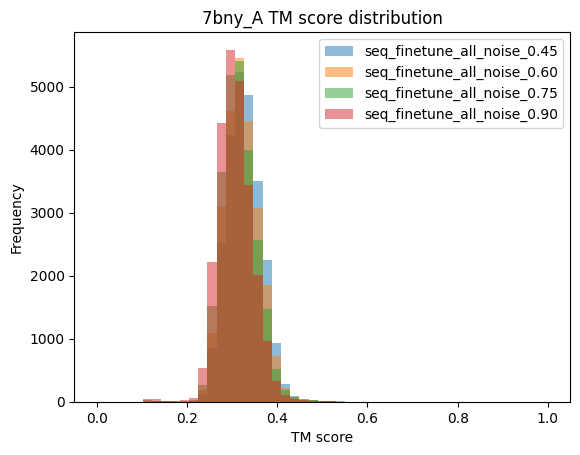

In [2]:
seq_finetune_all_purge_7bny_noise_045_aln_df = pd.read_csv(Path.home() / "proteina/inference/inference_seq_cond_sampling_finetune-all_21-seq_purge-7bny_045-noise/7bny_A/aln.tsv", sep="\t")
seq_finetune_all_purge_7bny_noise_060_aln_df = pd.read_csv(Path.home() / "proteina/inference/inference_seq_cond_sampling_finetune-all_21-seq_purge-7bny_060-noise/7bny_A/aln.tsv", sep="\t")
seq_finetune_all_purge_7bny_noise_075_aln_df = pd.read_csv(Path.home() / "proteina/inference/inference_seq_cond_sampling_finetune-all_21-seq_purge-7bny_075-noise/7bny_A/aln.tsv", sep="\t")
seq_finetune_all_purge_7bny_noise_090_aln_df = pd.read_csv(Path.home() / "proteina/inference/inference_seq_cond_sampling_finetune-all_21-seq_purge-7bny_090-noise/7bny_A/aln.tsv", sep="\t")

plt.hist(seq_finetune_all_purge_7bny_noise_045_aln_df["TM1"].to_numpy(), alpha=0.5, bins=np.linspace(0, 1, 50), label="seq_finetune_all_noise_0.45")
plt.hist(seq_finetune_all_purge_7bny_noise_060_aln_df["TM1"].to_numpy(), alpha=0.5, bins=np.linspace(0, 1, 50), label="seq_finetune_all_noise_0.60")
plt.hist(seq_finetune_all_purge_7bny_noise_075_aln_df["TM1"].to_numpy(), alpha=0.5, bins=np.linspace(0, 1, 50), label="seq_finetune_all_noise_0.75")
plt.hist(seq_finetune_all_purge_7bny_noise_090_aln_df["TM1"].to_numpy(), alpha=0.5, bins=np.linspace(0, 1, 50), label="seq_finetune_all_noise_0.90")
plt.xlabel("TM score")
plt.ylabel("Frequency")
plt.title("7bny_A TM score distribution")
plt.legend()
plt.show()


In [3]:
print(seq_finetune_all_purge_7bny_noise_045_aln_df.sort_values(by="TM1", ascending=False).head(3)["TM1"])
print(seq_finetune_all_purge_7bny_noise_060_aln_df.sort_values(by="TM1", ascending=False).head(3)["TM1"])
print(seq_finetune_all_purge_7bny_noise_075_aln_df.sort_values(by="TM1", ascending=False).head(3)["TM1"])
print(seq_finetune_all_purge_7bny_noise_090_aln_df.sort_values(by="TM1", ascending=False).head(3)["TM1"])


5333     0.5922
21495    0.5899
12124    0.5846
Name: TM1, dtype: float64
14555    0.5906
15034    0.5876
3993     0.5623
Name: TM1, dtype: float64
673      0.5577
24549    0.5300
16449    0.5288
Name: TM1, dtype: float64
12956    0.5624
18096    0.5257
13410    0.5203
Name: TM1, dtype: float64


In [4]:
print(seq_finetune_all_purge_7bny_noise_045_aln_df.sort_values(by="TM1", ascending=False).head(3)["PDBchain2"].iloc[0])
print(seq_finetune_all_purge_7bny_noise_060_aln_df.sort_values(by="TM1", ascending=False).head(3)["PDBchain2"].iloc[0])


/./7bny_A_cath_x.x.x.x_5333.pdb:A
/./7bny_A_cath_x.x.x.x_14555.pdb:A


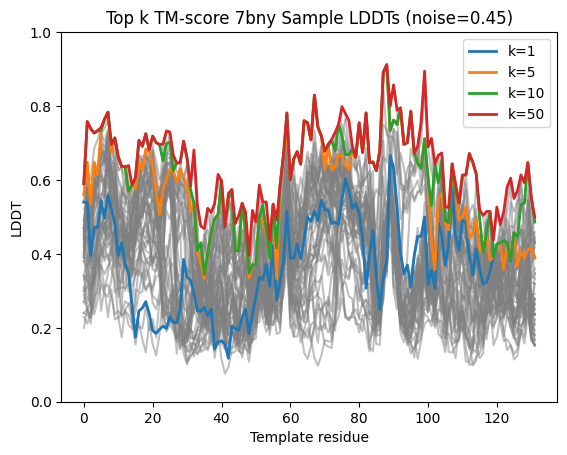

In [24]:
from pathlib import Path
from Bio.PDB import PDBParser, is_aa
import numpy as np

alpha_1 = list("ARNDCQEGHILKMFPSTWYVX-")
states = len(alpha_1)
alpha_3 = ['ALA','ARG','ASN','ASP','CYS','GLN','GLU','GLY','HIS','ILE',
            'LEU','LYS','MET','PHE','PRO','SER','THR','TRP','TYR','VAL','UNK','GAP']

aa_1_N = {a:n for n,a in enumerate(alpha_1)}
aa_3_N = {a:n for n,a in enumerate(alpha_3)}
aa_N_1 = {n:a for n,a in enumerate(alpha_1)}
aa_N_3 = {n:a for n,a in enumerate(alpha_3)}
aa_1_3 = {a:b for a,b in zip(alpha_1,alpha_3)}
aa_3_1 = {b:a for a,b in zip(alpha_1,alpha_3)}


def get_atom_pdb(pdb_file, chain_id, atom_id="CA", model_id=0):
    pdb_parser = PDBParser(QUIET=True)
    pdb = pdb_parser.get_structure("", pdb_file)
    model = pdb[model_id]
    chain = model[chain_id]
    seq = []
    coords = []
    for res in chain.get_residues():
        if is_aa(res) and res.get_resname() in aa_3_1:
            # Append the coordinates of each atom
            # Skip any without a CA atom
            ca_coord = [atom.get_coord() for atom in res if atom.name == atom_id]
            if len(ca_coord) > 0:
                coords.append(ca_coord[0])
                seq.append(aa_3_1[res.get_resname()])
    # Convert coordinates list to numpy array
    coords = np.array(coords)
    return coords, seq

# Implement local distance difference test with cutoff of 0.5A, 1.0A, 2.0A, 4.0A. The global cutoff for averaging is 15A.
def compute_lddt(gt_coord, template_coord, cutoff=15, local_cutoff=[0.5, 1.0, 2.0, 4.0]):
    gt_dist = np.linalg.norm(gt_coord[None, :, :] - gt_coord[:, None, :], axis=-1)
    template_dist = np.linalg.norm(template_coord[None, :, :] - template_coord[:, None, :], axis=-1)
    global_dist_mask = gt_dist < cutoff
    dist_diff = np.abs(gt_dist - template_dist)
    local_dist_mask = np.zeros((len(local_cutoff), len(gt_coord), len(gt_coord)))
    for i, cutoff in enumerate(local_cutoff):
        local_dist_mask[i] = dist_diff < cutoff
    lddt = np.mean(local_dist_mask, axis=0)
    lddt = (global_dist_mask * lddt).sum(axis=0) / global_dist_mask.sum(axis=0)
    return lddt

gt_pdb = Path.home() / "data/7bny_example/7bny.pdb"
gt_coord, gt_seq = get_atom_pdb(gt_pdb, "A")
top_k = 50
template_pdbs = seq_finetune_all_purge_7bny_noise_045_aln_df.sort_values(by="TM1", ascending=False).head(top_k)["PDBchain2"]
lddt_list = []
for template_pdb in template_pdbs:
    template_pdb = Path(Path.home() / "proteina/inference/inference_seq_cond_sampling_finetune-all_21-seq_purge-7bny_045-noise/7bny_A") / template_pdb.split(":")[0][1:]
    template_coord, template_seq = get_atom_pdb(template_pdb, "A")

    lddt = compute_lddt(gt_coord, template_coord, cutoff=15, local_cutoff=[0.5, 1.0, 2.0, 4.0])
    lddt_list.append(lddt)

for i in range(len(lddt_list)): plt.plot(lddt_list[i], alpha=0.5, color="gray")
for k in [1 , 5, 10, 50]: plt.plot(np.max(lddt_list[:k], axis=0), label=f"k={k}", linewidth=2)
plt.xlabel("Template residue")
plt.ylabel("LDDT")
plt.ylim(0, 1)
plt.title(f"Top k TM-score 7bny Sample LDDTs (noise=0.45)")
plt.legend()
plt.show()


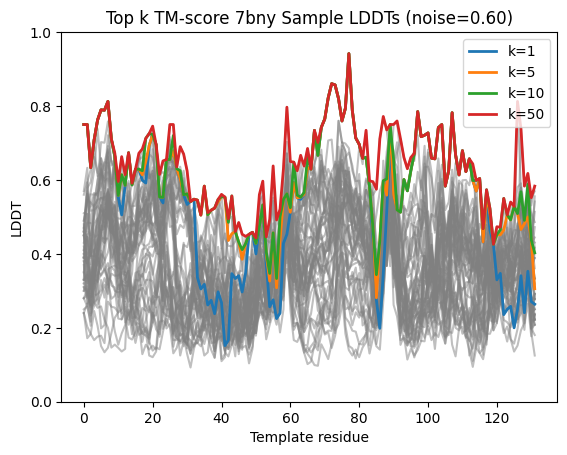

In [25]:
from pathlib import Path
from Bio.PDB import PDBParser, is_aa
import numpy as np

alpha_1 = list("ARNDCQEGHILKMFPSTWYVX-")
states = len(alpha_1)
alpha_3 = ['ALA','ARG','ASN','ASP','CYS','GLN','GLU','GLY','HIS','ILE',
            'LEU','LYS','MET','PHE','PRO','SER','THR','TRP','TYR','VAL','UNK','GAP']

aa_1_N = {a:n for n,a in enumerate(alpha_1)}
aa_3_N = {a:n for n,a in enumerate(alpha_3)}
aa_N_1 = {n:a for n,a in enumerate(alpha_1)}
aa_N_3 = {n:a for n,a in enumerate(alpha_3)}
aa_1_3 = {a:b for a,b in zip(alpha_1,alpha_3)}
aa_3_1 = {b:a for a,b in zip(alpha_1,alpha_3)}


def get_atom_pdb(pdb_file, chain_id, atom_id="CA", model_id=0):
    pdb_parser = PDBParser(QUIET=True)
    pdb = pdb_parser.get_structure("", pdb_file)
    model = pdb[model_id]
    chain = model[chain_id]
    seq = []
    coords = []
    for res in chain.get_residues():
        if is_aa(res) and res.get_resname() in aa_3_1:
            # Append the coordinates of each atom
            # Skip any without a CA atom
            ca_coord = [atom.get_coord() for atom in res if atom.name == atom_id]
            if len(ca_coord) > 0:
                coords.append(ca_coord[0])
                seq.append(aa_3_1[res.get_resname()])
    # Convert coordinates list to numpy array
    coords = np.array(coords)
    return coords, seq

# Implement local distance difference test with cutoff of 0.5A, 1.0A, 2.0A, 4.0A. The global cutoff for averaging is 15A.
def compute_lddt(gt_coord, template_coord, cutoff=15, local_cutoff=[0.5, 1.0, 2.0, 4.0]):
    gt_dist = np.linalg.norm(gt_coord[None, :, :] - gt_coord[:, None, :], axis=-1)
    template_dist = np.linalg.norm(template_coord[None, :, :] - template_coord[:, None, :], axis=-1)
    global_dist_mask = gt_dist < cutoff
    dist_diff = np.abs(gt_dist - template_dist)
    local_dist_mask = np.zeros((len(local_cutoff), len(gt_coord), len(gt_coord)))
    for i, cutoff in enumerate(local_cutoff):
        local_dist_mask[i] = dist_diff < cutoff
    lddt = np.mean(local_dist_mask, axis=0)
    lddt = (global_dist_mask * lddt).sum(axis=0) / global_dist_mask.sum(axis=0)
    return lddt

gt_pdb = Path.home() / "data/7bny_example/7bny.pdb"
gt_coord, gt_seq = get_atom_pdb(gt_pdb, "A")
top_k = 50
template_pdbs = seq_finetune_all_purge_7bny_noise_060_aln_df.sort_values(by="TM1", ascending=False).head(top_k)["PDBchain2"]
lddt_list = []
for template_pdb in template_pdbs:
    template_pdb = Path(Path.home() / "proteina/inference/inference_seq_cond_sampling_finetune-all_21-seq_purge-7bny_060-noise/7bny_A") / template_pdb.split(":")[0][1:]
    template_coord, template_seq = get_atom_pdb(template_pdb, "A")

    lddt = compute_lddt(gt_coord, template_coord, cutoff=15, local_cutoff=[0.5, 1.0, 2.0, 4.0])
    lddt_list.append(lddt)

for i in range(len(lddt_list)): plt.plot(lddt_list[i], alpha=0.5, color="gray")
for k in [1 , 5, 10, 50]: plt.plot(np.max(lddt_list[:k], axis=0), label=f"k={k}", linewidth=2)
plt.xlabel("Template residue")
plt.ylabel("LDDT")
plt.ylim(0, 1)
plt.title(f"Top k TM-score 7bny Sample LDDTs (noise=0.60)")
plt.legend()
plt.show()


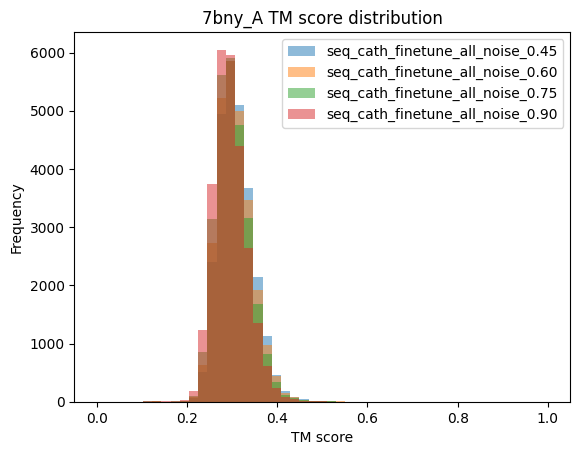

In [15]:
seq_cath_finetune_all_purge_7bny_noise_045_aln_df = pd.read_csv(Path.home() / "proteina/inference/inference_seq_cath_cond_sampling_finetune-all_21-seq_purge-7bny_045-noise/7bny_A/aln.tsv", sep="\t")
seq_cath_finetune_all_purge_7bny_noise_060_aln_df = pd.read_csv(Path.home() / "proteina/inference/inference_seq_cath_cond_sampling_finetune-all_21-seq_purge-7bny_060-noise/7bny_A/aln.tsv", sep="\t")
seq_cath_finetune_all_purge_7bny_noise_075_aln_df = pd.read_csv(Path.home() / "proteina/inference/inference_seq_cath_cond_sampling_finetune-all_21-seq_purge-7bny_075-noise/7bny_A/aln.tsv", sep="\t")
seq_cath_finetune_all_purge_7bny_noise_090_aln_df = pd.read_csv(Path.home() / "proteina/inference/inference_seq_cath_cond_sampling_finetune-all_21-seq_purge-7bny_090-noise/7bny_A/aln.tsv", sep="\t")

plt.hist(seq_cath_finetune_all_purge_7bny_noise_045_aln_df["TM1"].to_numpy(), alpha=0.5, bins=np.linspace(0, 1, 50), label="seq_cath_finetune_all_noise_0.45")
plt.hist(seq_cath_finetune_all_purge_7bny_noise_060_aln_df["TM1"].to_numpy(), alpha=0.5, bins=np.linspace(0, 1, 50), label="seq_cath_finetune_all_noise_0.60")
plt.hist(seq_cath_finetune_all_purge_7bny_noise_075_aln_df["TM1"].to_numpy(), alpha=0.5, bins=np.linspace(0, 1, 50), label="seq_cath_finetune_all_noise_0.75")
plt.hist(seq_cath_finetune_all_purge_7bny_noise_090_aln_df["TM1"].to_numpy(), alpha=0.5, bins=np.linspace(0, 1, 50), label="seq_cath_finetune_all_noise_0.90")
plt.xlabel("TM score")
plt.ylabel("Frequency")
plt.title("7bny_A TM score distribution")
plt.legend()
plt.show()


In [ ]:
# Fixed version of the problematic code
with open(Path.home() / "proteina/inference/inference_seq_cath_cond_sampling_finetune-all_21-seq_purge-7bny_060-noise/7bny_A/sampled_files.txt", "r") as f:
    sampled_files = [line.strip() for line in f.readlines()]

sampled_indices = []
sampled_tms = []
out_names = seq_cath_finetune_all_purge_7bny_noise_060_aln_df["PDBchain2"].str.split("/").str[-1].str.split(":").str[0]
print(out_names)

for file in sampled_files:
    print(file)
    
    # CORRECT METHOD 1: Using .loc with boolean indexing
    matching_mask = (out_names == file)
    if matching_mask.any():
        idx = out_names[matching_mask].index[0]
        print(f"Found match at index: {idx}")
        sampled_indices.append(idx)
        sampled_tms.append(tms[idx])
    else:
        print(f"No match found for {file}")
        
    # ALTERNATIVE METHOD 2: Using pandas .idxmax() 
    # idx = out_names[out_names == file].index
    # if len(idx) > 0:
    #     actual_idx = idx[0]
    #     print(f"Found match at index: {actual_idx}")
    #     sampled_indices.append(actual_idx)
    #     sampled_tms.append(tms[actual_idx])
    # else:
    #     print(f"No match found for {file}")
        
    # ALTERNATIVE METHOD 3: Using numpy.where
    # import numpy as np
    # idx_array = np.where(out_names == file)[0]
    # if len(idx_array) > 0:
    #     idx = idx_array[0]
    #     print(f"Found match at index: {idx}")
    #     sampled_indices.append(idx)
    #     sampled_tms.append(tms[idx])
    # else:
    #     print(f"No match found for {file}")


In [4]:
print(seq_cath_finetune_all_purge_7bny_noise_045_aln_df.sort_values(by="TM1", ascending=False).head(3)["TM1"])
print(seq_cath_finetune_all_purge_7bny_noise_060_aln_df.sort_values(by="TM1", ascending=False).head(3)["TM1"])
print(seq_cath_finetune_all_purge_7bny_noise_075_aln_df.sort_values(by="TM1", ascending=False).head(3)["TM1"])
print(seq_cath_finetune_all_purge_7bny_noise_090_aln_df.sort_values(by="TM1", ascending=False).head(3)["TM1"])


8540     0.6071
1979     0.6020
20722    0.5966
Name: TM1, dtype: float64
21495    0.6264
4863     0.5840
20722    0.5511
Name: TM1, dtype: float64
26212    0.6005
4863     0.5693
18253    0.5426
Name: TM1, dtype: float64
26212    0.5819
7070     0.5569
4863     0.5298
Name: TM1, dtype: float64


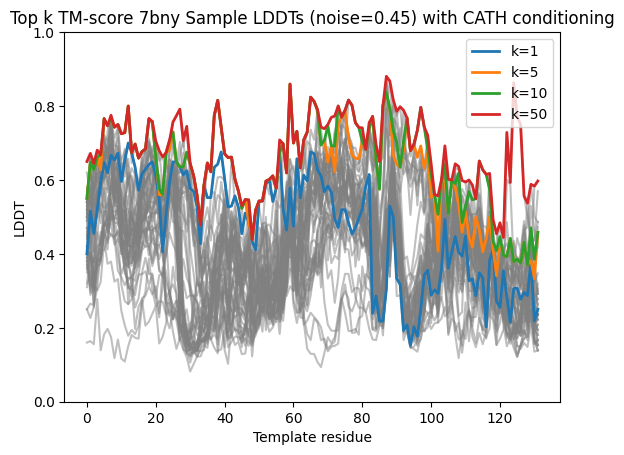

In [27]:
from pathlib import Path
from Bio.PDB import PDBParser, is_aa
import numpy as np

alpha_1 = list("ARNDCQEGHILKMFPSTWYVX-")
states = len(alpha_1)
alpha_3 = ['ALA','ARG','ASN','ASP','CYS','GLN','GLU','GLY','HIS','ILE',
            'LEU','LYS','MET','PHE','PRO','SER','THR','TRP','TYR','VAL','UNK','GAP']

aa_1_N = {a:n for n,a in enumerate(alpha_1)}
aa_3_N = {a:n for n,a in enumerate(alpha_3)}
aa_N_1 = {n:a for n,a in enumerate(alpha_1)}
aa_N_3 = {n:a for n,a in enumerate(alpha_3)}
aa_1_3 = {a:b for a,b in zip(alpha_1,alpha_3)}
aa_3_1 = {b:a for a,b in zip(alpha_1,alpha_3)}


def get_atom_pdb(pdb_file, chain_id, atom_id="CA", model_id=0):
    pdb_parser = PDBParser(QUIET=True)
    pdb = pdb_parser.get_structure("", pdb_file)
    model = pdb[model_id]
    chain = model[chain_id]
    seq = []
    coords = []
    for res in chain.get_residues():
        if is_aa(res) and res.get_resname() in aa_3_1:
            # Append the coordinates of each atom
            # Skip any without a CA atom
            ca_coord = [atom.get_coord() for atom in res if atom.name == atom_id]
            if len(ca_coord) > 0:
                coords.append(ca_coord[0])
                seq.append(aa_3_1[res.get_resname()])
    # Convert coordinates list to numpy array
    coords = np.array(coords)
    return coords, seq

# Implement local distance difference test with cutoff of 0.5A, 1.0A, 2.0A, 4.0A. The global cutoff for averaging is 15A.
def compute_lddt(gt_coord, template_coord, cutoff=15, local_cutoff=[0.5, 1.0, 2.0, 4.0]):
    gt_dist = np.linalg.norm(gt_coord[None, :, :] - gt_coord[:, None, :], axis=-1)
    template_dist = np.linalg.norm(template_coord[None, :, :] - template_coord[:, None, :], axis=-1)
    global_dist_mask = gt_dist < cutoff
    dist_diff = np.abs(gt_dist - template_dist)
    local_dist_mask = np.zeros((len(local_cutoff), len(gt_coord), len(gt_coord)))
    for i, cutoff in enumerate(local_cutoff):
        local_dist_mask[i] = dist_diff < cutoff
    lddt = np.mean(local_dist_mask, axis=0)
    lddt = (global_dist_mask * lddt).sum(axis=0) / global_dist_mask.sum(axis=0)
    return lddt

gt_pdb = Path.home() / "data/7bny_example/7bny.pdb"
gt_coord, gt_seq = get_atom_pdb(gt_pdb, "A")
top_k = 50
template_pdbs = seq_cath_finetune_all_purge_7bny_noise_045_aln_df.sort_values(by="TM1", ascending=False).head(top_k)["PDBchain2"]
lddt_list = []
for template_pdb in template_pdbs:
    template_pdb = Path(Path.home() / "proteina/inference/inference_seq_cath_cond_sampling_finetune-all_21-seq_purge-7bny_045-noise/7bny_A") / template_pdb.split(":")[0][1:]
    template_coord, template_seq = get_atom_pdb(template_pdb, "A")

    lddt = compute_lddt(gt_coord, template_coord, cutoff=15, local_cutoff=[0.5, 1.0, 2.0, 4.0])
    lddt_list.append(lddt)

for i in range(len(lddt_list)): plt.plot(lddt_list[i], alpha=0.5, color="gray")
for k in [1 , 5, 10, 50]: plt.plot(np.max(lddt_list[:k], axis=0), label=f"k={k}", linewidth=2)
plt.xlabel("Template residue")
plt.ylabel("LDDT")
plt.ylim(0, 1)
plt.title(f"Top k TM-score 7bny Sample LDDTs (noise=0.45) with CATH conditioning")
plt.legend()
plt.show()


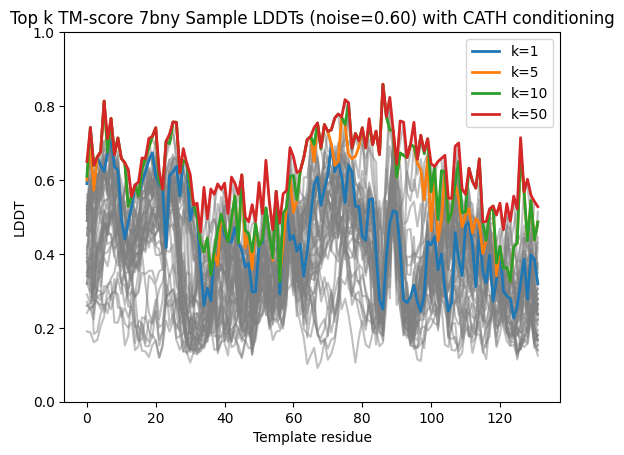

In [28]:
from pathlib import Path
from Bio.PDB import PDBParser, is_aa
import numpy as np

alpha_1 = list("ARNDCQEGHILKMFPSTWYVX-")
states = len(alpha_1)
alpha_3 = ['ALA','ARG','ASN','ASP','CYS','GLN','GLU','GLY','HIS','ILE',
            'LEU','LYS','MET','PHE','PRO','SER','THR','TRP','TYR','VAL','UNK','GAP']

aa_1_N = {a:n for n,a in enumerate(alpha_1)}
aa_3_N = {a:n for n,a in enumerate(alpha_3)}
aa_N_1 = {n:a for n,a in enumerate(alpha_1)}
aa_N_3 = {n:a for n,a in enumerate(alpha_3)}
aa_1_3 = {a:b for a,b in zip(alpha_1,alpha_3)}
aa_3_1 = {b:a for a,b in zip(alpha_1,alpha_3)}


def get_atom_pdb(pdb_file, chain_id, atom_id="CA", model_id=0):
    pdb_parser = PDBParser(QUIET=True)
    pdb = pdb_parser.get_structure("", pdb_file)
    model = pdb[model_id]
    chain = model[chain_id]
    seq = []
    coords = []
    for res in chain.get_residues():
        if is_aa(res) and res.get_resname() in aa_3_1:
            # Append the coordinates of each atom
            # Skip any without a CA atom
            ca_coord = [atom.get_coord() for atom in res if atom.name == atom_id]
            if len(ca_coord) > 0:
                coords.append(ca_coord[0])
                seq.append(aa_3_1[res.get_resname()])
    # Convert coordinates list to numpy array
    coords = np.array(coords)
    return coords, seq

# Implement local distance difference test with cutoff of 0.5A, 1.0A, 2.0A, 4.0A. The global cutoff for averaging is 15A.
def compute_lddt(gt_coord, template_coord, cutoff=15, local_cutoff=[0.5, 1.0, 2.0, 4.0]):
    gt_dist = np.linalg.norm(gt_coord[None, :, :] - gt_coord[:, None, :], axis=-1)
    template_dist = np.linalg.norm(template_coord[None, :, :] - template_coord[:, None, :], axis=-1)
    global_dist_mask = gt_dist < cutoff
    dist_diff = np.abs(gt_dist - template_dist)
    local_dist_mask = np.zeros((len(local_cutoff), len(gt_coord), len(gt_coord)))
    for i, cutoff in enumerate(local_cutoff):
        local_dist_mask[i] = dist_diff < cutoff
    lddt = np.mean(local_dist_mask, axis=0)
    lddt = (global_dist_mask * lddt).sum(axis=0) / global_dist_mask.sum(axis=0)
    return lddt

gt_pdb = Path.home() / "data/7bny_example/7bny.pdb"
gt_coord, gt_seq = get_atom_pdb(gt_pdb, "A")
top_k = 50
template_pdbs = seq_cath_finetune_all_purge_7bny_noise_060_aln_df.sort_values(by="TM1", ascending=False).head(top_k)["PDBchain2"]
lddt_list = []
for template_pdb in template_pdbs:
    template_pdb = Path(Path.home() / "proteina/inference/inference_seq_cath_cond_sampling_finetune-all_21-seq_purge-7bny_060-noise/7bny_A") / template_pdb.split(":")[0][1:]
    template_coord, template_seq = get_atom_pdb(template_pdb, "A")

    lddt = compute_lddt(gt_coord, template_coord, cutoff=15, local_cutoff=[0.5, 1.0, 2.0, 4.0])
    lddt_list.append(lddt)

for i in range(len(lddt_list)): plt.plot(lddt_list[i], alpha=0.5, color="gray")
for k in [1 , 5, 10, 50]: plt.plot(np.max(lddt_list[:k], axis=0), label=f"k={k}", linewidth=2)
plt.xlabel("Template residue")
plt.ylabel("LDDT")
plt.ylim(0, 1)
plt.title(f"Top k TM-score 7bny Sample LDDTs (noise=0.60) with CATH conditioning")
plt.legend()
plt.show()


In [ ]:
from pathlib import Path
from Bio.PDB import PDBParser, is_aa
import numpy as np

alpha_1 = list("ARNDCQEGHILKMFPSTWYVX-")
states = len(alpha_1)
alpha_3 = ['ALA','ARG','ASN','ASP','CYS','GLN','GLU','GLY','HIS','ILE',
            'LEU','LYS','MET','PHE','PRO','SER','THR','TRP','TYR','VAL','UNK','GAP']

aa_1_N = {a:n for n,a in enumerate(alpha_1)}
aa_3_N = {a:n for n,a in enumerate(alpha_3)}
aa_N_1 = {n:a for n,a in enumerate(alpha_1)}
aa_N_3 = {n:a for n,a in enumerate(alpha_3)}
aa_1_3 = {a:b for a,b in zip(alpha_1,alpha_3)}
aa_3_1 = {b:a for a,b in zip(alpha_1,alpha_3)}


def get_atom_pdb(pdb_file, chain_id, atom_id="CA", model_id=0):
    pdb_parser = PDBParser(QUIET=True)
    pdb = pdb_parser.get_structure("", pdb_file)
    model = pdb[model_id]
    chain = model[chain_id]
    seq = []
    coords = []
    for res in chain.get_residues():
        if is_aa(res) and res.get_resname() in aa_3_1:
            # Append the coordinates of each atom
            # Skip any without a CA atom
            ca_coord = [atom.get_coord() for atom in res if atom.name == atom_id]
            if len(ca_coord) > 0:
                coords.append(ca_coord[0])
                seq.append(aa_3_1[res.get_resname()])
    # Convert coordinates list to numpy array
    coords = np.array(coords)
    return coords, seq

# Implement local distance difference test with cutoff of 0.5A, 1.0A, 2.0A, 4.0A. The global cutoff for averaging is 15A.
def lddt(gt_coord, template_coord, cutoff=15, local_cutoff=[0.5, 1.0, 2.0, 4.0]):
    gt_dist = np.linalg.norm(gt_coord[None, :, :] - gt_coord[:, None, :], axis=-1)
    template_dist = np.linalg.norm(template_coord[None, :, :] - template_coord[:, None, :], axis=-1)
    global_dist_mask = gt_dist < cutoff
    dist_diff = np.abs(gt_dist - template_dist)
    local_dist_mask = np.zeros((len(local_cutoff), len(gt_coord), len(gt_coord)))
    for i, cutoff in enumerate(local_cutoff):
        local_dist_mask[i] = dist_diff < cutoff
    lddt = np.mean(local_dist_mask, axis=0)
    lddt = (global_dist_mask * lddt).sum(axis=0) / global_dist_mask.sum(axis=0)
    return lddt

gt_pdb = Path.home() / "data/7bny_example/7bny.pdb"
template_pdb = Path(Path.home() / "proteina/inference/inference_seq_cath_cond_sampling_finetune-all_21-seq_purge-7bny_045-noise/7bny_A") / Path(seq_cath_finetune_all_purge_7bny_noise_045_aln_df.sort_values(by="TM1", ascending=False).head(3)["PDBchain2"].iloc[0].split(":")[0][1:])

gt_coord, gt_seq = get_atom_pdb(gt_pdb, "A")
template_coord, template_seq = get_atom_pdb(template_pdb, "A")

lddt = lddt(gt_coord, template_coord, cutoff=15, local_cutoff=[0.5, 1.0, 2.0, 4.0])

plt.plot(lddt)
plt.xlabel("Template residue")
plt.ylabel("LDDT")
plt.show()


In [5]:
print(seq_cath_finetune_all_purge_7bny_noise_045_aln_df.sort_values(by="TM1", ascending=False).head(3)["PDBchain2"].iloc[0])
print(seq_cath_finetune_all_purge_7bny_noise_060_aln_df.sort_values(by="TM1", ascending=False).head(3)["PDBchain2"].iloc[0])


/./7bny_A_cath_2.20.25.290_4.pdb:A
/./7bny_A_cath_4.10.49.10_7.pdb:A


In [6]:
print(seq_cath_finetune_all_purge_7bny_noise_060_aln_df[seq_cath_finetune_all_purge_7bny_noise_060_aln_df["PDBchain2"].str.contains("4.10.49.10")])


                                              #PDBchain1  \
21488  /home/jupyter-chenxi/proteina/data/pdb_train/r...   
21489  /home/jupyter-chenxi/proteina/data/pdb_train/r...   
21490  /home/jupyter-chenxi/proteina/data/pdb_train/r...   
21491  /home/jupyter-chenxi/proteina/data/pdb_train/r...   
21492  /home/jupyter-chenxi/proteina/data/pdb_train/r...   
21493  /home/jupyter-chenxi/proteina/data/pdb_train/r...   
21494  /home/jupyter-chenxi/proteina/data/pdb_train/r...   
21495  /home/jupyter-chenxi/proteina/data/pdb_train/r...   

                               PDBchain2     TM1     TM2  RMSD    ID1    ID2  \
21488  /./7bny_A_cath_4.10.49.10_0.pdb:A  0.2998  0.2998  4.37  0.220  0.220   
21489  /./7bny_A_cath_4.10.49.10_1.pdb:A  0.3365  0.3365  4.48  0.061  0.061   
21490  /./7bny_A_cath_4.10.49.10_2.pdb:A  0.2821  0.2821  4.31  0.045  0.045   
21491  /./7bny_A_cath_4.10.49.10_3.pdb:A  0.3510  0.3510  3.40  0.182  0.182   
21492  /./7bny_A_cath_4.10.49.10_4.pdb:A  0.3285  0.3285  4

## Dataset

In [3]:
L.seed_everything(42)
version_base = hydra.__version__
config_path = Path.home() / "proteina/configs/datasets_config"
hydra.initialize_config_dir(config_dir=f"{config_path}/pdb", version_base=version_base)

cfg = hydra.compose(
    config_name="pdb_train_S25_max384_purge-test",
    return_hydra_config=True,
)
pdb_datamodule = hydra.utils.instantiate(cfg.datamodule)
pdb_datamodule.prepare_data()
pdb_datamodule.setup("fit")
pdb_train_dataloader = pdb_datamodule.train_dataloader()
 

Seed set to 42
Processing Uniprot/PDB CATH map...
Processing CATH ID to CATH code map...
df_pdb_f1_minl50_maxl384_mtprotein_etdiffractionEM_minoNone_maxoNone_minr0.0_maxr5.0_hl_rl_rnsrTrue_rpuTrue_l_rcuFalse_ex12.csv already exists, skipping data selection and processing stage.
Loading dataset csv from df_pdb_f1_minl50_maxl384_mtprotein_etdiffractionEM_minoNone_maxoNone_minr0.0_maxr5.0_hl_rl_rnsrTrue_rpuTrue_l_rcuFalse_ex12.csv
Splitting dataset via sequence-similarity split into [0.98, 0.019, 0.001]...
Using 0.25 sequence similarity for split


In [ ]:
af2rank_df = Path.home() / "data/af2rank_single/af2rank_single_set_combined_tms.csv"
af2rank_df = pd.read_csv(af2rank_df)
print(len(af2rank_df))
train_id = set(pdb_datamodule._get_dataset("train").file_names)
print(len(train_id), type(train_id))
print(sum(af2rank_df["natives_rcsb"].isin(train_id)))
af2rank_df["in_train"] = af2rank_df["natives_rcsb"].isin(train_id)
af2rank_df.to_csv(Path.home() / "data/af2rank_single/af2rank_single_set_combined_tms_in_train.csv", index=False)


453789 <class 'set'>
141


In [6]:
bad_afdb_df = pd.read_csv(Path.home() / "data/bad_afdb/pdb_70_cluster_reps_aligned_confidence_aggregate_plddt_50_length_50-768_tms.csv")
print(len(bad_afdb_df))
train_id = set(pdb_datamodule._get_dataset("train").file_names)
def lower_pdb(pdb):
    pdb, chain = pdb.split("_")
    pdb = pdb.lower()
    return f"{pdb}_{chain}"
bad_afdb_df["in_train"] = bad_afdb_df['pdb'].apply(lambda x: lower_pdb(x)).isin(train_id)
print(f"In train: {sum(bad_afdb_df['in_train'])}/{len(bad_afdb_df)}")
bad_afdb_df.to_csv(Path.home() / "data/bad_afdb/pdb_70_cluster_reps_aligned_confidence_aggregate_plddt_50_length_50-768_tms_in-train.csv", index=False)


143
In train: 58/143


In [10]:
print(bad_afdb_df["pdb"][:5])
print(pdb_datamodule._get_dataset("train").file_names[:5])

0     6guw_A
1     6klb_B
2     6kw4_L
3     6ldv_L
4    6sg9_Ci
Name: pdb, dtype: object
['4k08_A', '2gmy_A', '2gmy_B', '2gmy_C', '2gmy_D']


In [12]:
val_id = set(pdb_datamodule._get_dataset("val").file_names)
print(len(val_id), type(val_id))
test_id = set(pdb_datamodule._get_dataset("test").file_names)
print(len(test_id), type(test_id))

print(train_id & val_id)
print(train_id & test_id)
print(val_id & test_id)

9956 <class 'set'>
273 <class 'set'>
set()
set()
set()


In [6]:
pdb_datamodule.df_data[pdb_datamodule.df_data["pdb"] == "1ubq"]

,id,pdb,chain,length,molecule_type,name,sequence,split,n_chains,ligands,source,resolution,deposition_date,experiment_type,pdb_file_available
24932,1ubq_A,1ubq,A,76,protein,UBIQUITIN,MQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPDQQRLIFA...,NaN,1,[],Homo sapiens,1.8,1987-01-02,diffraction,True


In [7]:
print(list(filter(lambda x: x in ["1ubq_A"], pdb_datamodule._get_dataset("train").file_names)))

['1ubq_A']


In [8]:
# print(pdb_datamodule.dataselector.exclude_ids, pdb_datamodule._get_dataset("train").file_names)
print(list(filter(lambda x: x in ["7bny_A", "7bny_B", "7bny_C", "7bny_D"], pdb_datamodule._get_dataset("train").file_names)))

[]


In [4]:
pdb_datamodule.df_data[pdb_datamodule.df_data["pdb"] == "7ll9"]

,id,pdb,chain,length,molecule_type,name,sequence,split,n_chains,ligands,source,resolution,deposition_date,experiment_type,pdb_file_available
231536,7ll9_A,7ll9,A,103,protein,Isoform L-VEGF189 of Vascular endothelial grow...,SGQNHHEVVKFMDVYQRSYCHPIETLVDIFQEYPDEIEYIFKPSCV...,NaN,8,"['DAL', 'DAR', 'DAS', 'DGL', 'DGN', 'DHI', 'DI...",Homo sapiens; SYNTHETIC CONSTRUCT,2.9,2021-02-03,diffraction,True
231537,7ll9_B,7ll9,B,103,protein,Isoform L-VEGF189 of Vascular endothelial grow...,SGQNHHEVVKFMDVYQRSYCHPIETLVDIFQEYPDEIEYIFKPSCV...,NaN,8,"['DAL', 'DAR', 'DAS', 'DGL', 'DGN', 'DHI', 'DI...",Homo sapiens; SYNTHETIC CONSTRUCT,2.9,2021-02-03,diffraction,True
231538,7ll9_E,7ll9,E,103,protein,Isoform L-VEGF189 of Vascular endothelial grow...,SGQNHHEVVKFMDVYQRSYCHPIETLVDIFQEYPDEIEYIFKPSCV...,NaN,8,"['DAL', 'DAR', 'DAS', 'DGL', 'DGN', 'DHI', 'DI...",Homo sapiens; SYNTHETIC CONSTRUCT,2.9,2021-02-03,diffraction,True
231539,7ll9_F,7ll9,F,103,protein,Isoform L-VEGF189 of Vascular endothelial grow...,SGQNHHEVVKFMDVYQRSYCHPIETLVDIFQEYPDEIEYIFKPSCV...,NaN,8,"['DAL', 'DAR', 'DAS', 'DGL', 'DGN', 'DHI', 'DI...",Homo sapiens; SYNTHETIC CONSTRUCT,2.9,2021-02-03,diffraction,True


In [5]:
print(pdb_train_dataloader.dataset[0])
print(pdb_train_dataloader.dataset[0].residues)
print(pdb_train_dataloader.dataset[0].residue_type)
print(pdb_train_dataloader.dataset[0].residue_pdb_idx)
print(pdb_train_dataloader.dataset[0].seq_pos)
print(pdb_train_dataloader.dataset[0].cath_code)


Data(coords=[256, 37, 3], residues=[208], id='9bce_A', residue_id=[208], residue_type=[256], chains=[256], bfactor=[256], coord_mask=[256, 37], database='pdb', bfactor_avg=19.72928620244606, residue_pdb_idx=[256], seq_pos=[256, 1], chain_breaks_per_residue=[256], cath_code=[0])
['ASP', 'VAL', 'SER', 'GLY', 'SER', 'LEU', 'ARG', 'ILE', 'ALA', 'ILE', 'PRO', 'VAL', 'SER', 'PHE', 'SER', 'GLN', 'GLU', 'LEU', 'ILE', 'ALA', 'ASN', 'LEU', 'CYS', 'SER', 'GLY', 'PHE', 'ARG', 'LEU', 'TYR', 'PRO', 'ASN', 'VAL', 'GLU', 'LEU', 'ASP', 'VAL', 'GLN', 'PHE', 'THR', 'ASP', 'ASN', 'ASP', 'ILE', 'GLY', 'LEU', 'VAL', 'GLY', 'GLU', 'GLY', 'TYR', 'ASP', 'ILE', 'ALA', 'ILE', 'LYS', 'TYR', 'GLY', 'PRO', 'LEU', 'GLN', 'SER', 'SER', 'ASP', 'LEU', 'VAL', 'ALA', 'ARG', 'LEU', 'LEU', 'PHE', 'GLU', 'ARG', 'GLN', 'PRO', 'ILE', 'LEU', 'VAL', 'ALA', 'SER', 'PRO', 'GLY', 'TYR', 'LEU', 'LYS', 'THR', 'ARG', 'GLY', 'THR', 'PRO', 'ALA', 'THR', 'PRO', 'LYS', 'GLU', 'LEU', 'SER', 'ASP', 'HIS', 'SER', 'GLY', 'ILE', 'LEU', 'LEU',

In [ ]:
len_cath_codes_lst = torch.load(Path.home() / "proteina/data/metric_factory/features/D_FS_afdb_cath_codes.pth")
print(len_cath_codes_lst)
print(filter(lambda x: x[0] == "4jnj", len_cath_codes_lst))

/tmp/ipykernel_3143434/2030198574.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  len_cath_codes_lst = torch.load("/home/jupyter-chenxi/proteina/data/metric_factory/feat

In [ ]:
import importlib
import sys
from graphein_utils import graphein_utils
from graphein_utils.graphein_utils import protein_to_pyg

# Ensure the module is in sys.modules before reloading
if 'graphein_utils.graphein_utils' in sys.modules:
    importlib.reload(graphein_utils)

protein_to_pyg(Path.home() / "proteina/data/pdb_train/raw/7ll9.cif.gz", pdb_code="7ll9", chain_selection="C")


In [ ]:
split_df = pd.DataFrame(["2.40.128"], columns=["cath_code"])
split_df.to_csv(fPath.home() / "proteina/data/pdb_train/test_cath_code.csv", index=False)
cath_transform = CATHLabelTransform(root_dir=Path.home() / "proteina/data/cathdata/")
pdbchain_to_cathid_mapping = cath_transform.pdbchain_to_cathid_mapping
cathid_to_cathcode_mapping = cath_transform.cathid_to_cathcode_mapping
cathid_to_segment_mapping = cath_transform.cathid_to_segment_mapping

print(len(pdbchain_to_cathid_mapping))
print(list(pdbchain_to_cathid_mapping.keys())[:10])
print(pdbchain_to_cathid_mapping[list(pdbchain_to_cathid_mapping.keys())[1]])

print(len(cathid_to_cathcode_mapping))
print(list(cathid_to_cathcode_mapping.keys())[:10])
print(cathid_to_cathcode_mapping[list(cathid_to_cathcode_mapping.keys())[1]])

print(len(cathid_to_segment_mapping))
print(list(cathid_to_segment_mapping.keys())[:10])
print(cathid_to_segment_mapping[list(cathid_to_segment_mapping.keys())[1]])

print(len(list(filter(lambda x: x[-2:] != "00", list(cathid_to_cathcode_mapping.keys())))))

for split in ["train", "val", "test"]:
    pdbs = pdb_datamodule._get_dataset(split).pdb_codes
    chains = pdb_datamodule._get_dataset(split).chains
    pdb_chains = set([f"{pdb}{chain}" for pdb, chain in zip(pdbs, chains)])
    cath = set()
    for cathid, cathcode in tqdm(cathid_to_cathcode_mapping.items()):
        if cathid[:5] in pdb_chains:
            cath.add(cathcode)
    print(f"{split} has {len(cath)} unique CATH codes")
    split_df = pd.DataFrame(list(cath), columns=["cath_code"])
    split_df.to_csv(fPath.home() / f"proteina/data/pdb_train/cath_codes_{split}_0.5_df_pdb_f1_minl50_maxl256_mtprotein_etdiffractionEM_minoNone_maxoNone_minr0.0_maxr5.0_hl_rl_rnsrTrue_rpuTrue_l_rcuFalse.csv", index=False)


In [ ]:
from pathlib import Path
from Bio.PDB import PDBParser, MMCIFParser

gt_pdb = Path.home() / "data/7bny_example/7bny.pdb"
template_pdb = Path(Path.home() / "proteina/inference/inference_seq_cath_cond_sampling_finetune-all_21-seq_purge-7bny_045-noise/7bny_A") / Path(seq_cath_finetune_all_purge_7bny_noise_045_aln_df.sort_values(by="TM1", ascending=False).head(3)["PDBchain2"].iloc[0].split(":")[0][1:])
print(gt_pdb)
print(template_pdb)

pdb_parser = PDBParser(QUIET=True)
gt_structure = pdb_parser.get_structure("gt", gt_pdb)
template_structure = pdb_parser.get_structure("template", template_pdb)

gt_coord = gt_structure.get_atoms()
template_coord = template_structure.get_atoms()

print(np.array(gt_coord))
print(np.array(template_coord))


In [3]:
L.seed_everything(43)
version_base = hydra.__version__
config_path = Path.home() / "proteina/configs/datasets_config"
hydra.initialize_config_dir(config_dir=f"{config_path}/pdb", version_base=version_base)

cfg = hydra.compose(
    config_name="pdb_train_S25_max320_purge-7bny-7kww-7ad5",
    return_hydra_config=True,
)
pdb_datamodule = hydra.utils.instantiate(cfg.datamodule)
pdb_datamodule.prepare_data()
pdb_datamodule.setup("fit")
pdb_train_dataloader = pdb_datamodule.train_dataloader()

cath_transform = CATHLabelTransform(root_dir=Path.home() / "proteina/data/cathdata/")
pdbchain_to_cathid_mapping = cath_transform.pdbchain_to_cathid_mapping
cathid_to_cathcode_mapping = cath_transform.cathid_to_cathcode_mapping
cathid_to_segment_mapping = cath_transform.cathid_to_segment_mapping


Seed set to 43
2025-07-29 19:56:59.300 | INFO     | proteinfoundation.datasets.transforms:__init__:231 - Processing Uniprot/PDB CATH map...
2025-07-29 19:57:01.380 | INFO     | proteinfoundation.datasets.transforms:__init__:233 - Processing CATH ID to CATH code map...
2025-07-29 19:57:08.015 | INFO     | proteinfoundation.datasets.pdb_data:prepare_data:525 - df_pdb_f1_minl50_maxl320_mtprotein_etdiffractionEM_minoNone_maxoNone_minr0.0_maxr5.0_hl_rl_rnsrTrue_rpuTrue_l_rcuFalse_ex11.csv already exists, skipping data selection and processing stage.
2025-07-29 19:57:08.016 | INFO     | proteinfoundation.datasets.pdb_data:setup:617 - Loading dataset csv from df_pdb_f1_minl50_maxl320_mtprotein_etdiffractionEM_minoNone_maxoNone_minr0.0_maxr5.0_hl_rl_rnsrTrue_rpuTrue_l_rcuFalse_ex11.csv
2025-07-29 19:57:10.822 | INFO     | proteinfoundation.datasets.pdb_data:split_data:289 - Splitting dataset via sequence-similarity split into [0.98, 0.019, 0.001]...
2025-07-29 19:57:10.824 | INFO     | protein

In [5]:
train_id = pdb_datamodule._get_dataset("train").file_names
val_id = pdb_datamodule._get_dataset("val").file_names
test_id = pdb_datamodule._get_dataset("test").file_names

print("7b76_A" in train_id)
print("7b76_A" in val_id)
print("7b76_A" in test_id)


True
False
False


In [ ]:
L.seed_everything(43)
version_base = hydra.__version__
config_path = Path.home() / "proteina/configs/datasets_config"
hydra.initialize_config_dir(config_dir=f"{config_path}/pdb", version_base=version_base)

cfg = hydra.compose(
    config_name="pdb_train_S25_max384_purge-7bny-7kww-7ad5",
    return_hydra_config=True,
)
pdb_datamodule = hydra.utils.instantiate(cfg.datamodule)
pdb_datamodule.prepare_data()
pdb_datamodule.setup("fit")
pdb_train_dataloader = pdb_datamodule.train_dataloader()

cath_transform = CATHLabelTransform(root_dir=Path.home() / "proteina/data/cathdata/")
pdbchain_to_cathid_mapping = cath_transform.pdbchain_to_cathid_mapping
cathid_to_cathcode_mapping = cath_transform.cathid_to_cathcode_mapping
cathid_to_segment_mapping = cath_transform.cathid_to_segment_mapping


for split in ["train", "val", "test"]:
    pdbs = pdb_datamodule._get_dataset(split).pdb_codes
    chains = pdb_datamodule._get_dataset(split).chains
    pdb_chains = set([f"{pdb}{chain}" for pdb, chain in zip(pdbs, chains)])
    cath = set()
    for cathid, cathcode in tqdm(cathid_to_cathcode_mapping.items()):
        if cathid[:5] in pdb_chains:
            cath.add(cathcode)
    print(f"{split} has {len(cath)} unique CATH codes")
    split_df = pd.DataFrame(list(cath), columns=["cath_code"])
    split_df.to_csv(Path.home() / f"proteina/data/pdb_train/cath_codes_{split}_df_pdb_f1_minl50_maxl384_mtprotein_etdiffractionEM_minoNone_maxoNone_minr0.0_maxr5.0_hl_rl_rnsrTrue_rpuTrue_l_rcuFalse_ex11.csv", index=False)
